In [1]:
import numpy as np
import scipy.io
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.optimize import fsolve
from scipy.optimize import leastsq
from scipy.signal import find_peaks
from scipy.integrate import solve_ivp
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
import scipy as sp
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["computer modern roman"],
    "font.size": 20})

plw = 0.6
pcs = 3
pms = 3
bfillc = [0.9,0.9,0.9]
plt.rcParams['axes.linewidth'] = plw
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = plw
plt.rcParams['xtick.minor.width'] = plw
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = plw
plt.rcParams['ytick.minor.width'] = plw
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams["figure.figsize"] = (5,4)

def mscatter(x,y,ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

/tmp/ipykernel_14067/1160853358.py:11: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,


In [68]:
## Load data
dataFUS = pd.read_excel(r'FUSsims.xlsx')
dataDDX = pd.read_excel(r'DDXsims.xlsx')

## Constants
## Avogadro
NA=6.02214076E23;
## kT
kT=2.49; #kJ/mol;

## Total Volume
VFUS=np.power(dataFUS.L,3)
p0FUS=kT*(dataFUS.Ntot)/VFUS
VDDX=np.power(dataDDX.L,3)
p0DDX=kT*(dataDDX.Ntot)/VDDX

## Densities
## mg/protein
weightFUS=2.85281E-17;
weightDDX=4.22275E-17;
ml_nm3=1E21;
## 
vlFUS=np.power(0.0185,-1); #nm3 from FUS density from radial density profile
vlDDX=np.power(0.0085,-1); #nm3 from NDDX4 density from radial density profile
## Output data table
print(dataFUS)
print(dataDDX)

  Simulation   L  Ntot  Nss
0      FUS-3  40    50   42
1      FUS-5  50    69   55
2      FUS-6  50    98   86
3      FUS-7  60    84   63
4      FUS-8  60   118  101
5      FUS-9  60   169  153
6     FUS-10  70   133  103
7     FUS-11  70   187  158
8     FUS-12  70   268  243
  Simulation   L  Ntot  Nss
0    NDDX4-5  50    69   45
1    NDDX4-6  50    98   76
2    NDDX4-7  60    84   42
3    NDDX4-8  60   118   84
4    NDDX4-9  60   169  139
5   NDDX4-10  70   133   71
6   NDDX4-11  70   187  130
7   NDDX4-12  70   268  214


In [3]:
#MSM model exchange time/rate 
MFPT_FUS = np.loadtxt("./MFPT_FUS.txt").T
MFPT_DDX4 = np.loadtxt("./MFPT_DDX4.txt").T
#import math
#MFPT_FUS_log=np.zeros(len(MFPT_FUS[0]))
#for i in range(len(MFPT_FUS[0])):
#    MFPT_FUS_log[i]=math.log(MFPT_FUS[0][i])
#MFPT_DDX4_log=np.zeros(len(MFPT_DDX4[0]))
#for i in range(len(MFPT_DDX4[0])):
#    MFPT_DDX4_log[i]=math.log(MFPT_DDX4[0][i])

In [4]:
#Define Function -> Equilibrium Condition
ERR=lambda tpl, p0, p1, vl, rss, kT, : p1-tpl[0]*np.exp(2*(tpl[1])*vl/(rss*kT)) #         
#Initial Guess

#Fitting BootStrap
REPS=1000

NsimulationsFUS=np.shape(dataFUS.L)[0]
peqFUS=np.zeros(REPS)
sigmaFUS=np.zeros(REPS)

NsimulationsDDX=np.shape(dataDDX.L)[0]
peqDDX=np.zeros(REPS)
sigmaDDX=np.zeros(REPS)

In [5]:
# Bootstrap estimate of the fitted parameters, FUS
for REP in np.arange(0,REPS):
    #choose Nsimulations random simulations (with repetition)
    simulations=np.random.randint(0,NsimulationsFUS,NsimulationsFUS)
    guess=np.random.rand(2);
    p1=kT*(dataFUS.Ntot[simulations]-dataFUS.Nss[simulations])/(VFUS[simulations]-dataFUS.Nss[simulations]*vlFUS)
    p0=kT*(dataFUS.Ntot[simulations])/VFUS[simulations]
    rss=np.power(3*dataFUS.Nss[simulations]*vlFUS/4/np.pi,1/3)
    
    #least squares fitting
    #tplFitted => tuple of fitted parameters
    tplFitted,success=leastsq(ERR,guess,args=(p0, p1, vlFUS,rss,kT),full_output=0,maxfev=1000,ftol=1E-15,gtol=1E-15)

    peqFUS[REP]=tplFitted[0]
    sigmaFUS[REP]=tplFitted[1]

In [6]:
# Bootstrap estimate of the fitted parameters, NDDX4
for REP in np.arange(0,REPS):
    #choose Nsimulations random simulations (with repetition)
    simulations=np.random.randint(0,NsimulationsDDX,NsimulationsDDX)
    guess=np.random.rand(2);
    p1=kT*(dataDDX.Ntot[simulations]-dataDDX.Nss[simulations])/(VDDX[simulations]-dataDDX.Nss[simulations]*vlDDX)
    p0=kT*(dataDDX.Ntot[simulations])/VDDX[simulations]
    rss=np.power(3*dataDDX.Nss[simulations]*vlDDX/4/np.pi,1/3)
    
    #least squares fitting
    #tplFitted => tuple of fitted parameters
    tplFitted,success=leastsq(ERR,guess,args=(p0, p1, vlDDX,rss,kT),full_output=0,maxfev=1000,ftol=1E-15,gtol=1E-15)

    peqDDX[REP]=tplFitted[0]
    sigmaDDX[REP]=tplFitted[1]

In [7]:
kT

2.49

In [8]:
0.00019*ml_nm3*weightDDX/kT*kT

8.023225

In [9]:
# Equilibrium vapour pressure
peq_FUS_estimate=np.mean(peqFUS)
peq_DDX_estimate=np.mean(peqDDX)

# Equilibrium density of the dilute phase FUS
LD_FUS=peqFUS; #mg/ml
LD_FUS_estimate=np.mean(LD_FUS)
LD_FUS_err=1.96*np.std(LD_FUS) # 95% confidence interval
# Equilibrium density of the dilute phase NDDX4
LD_DDX=peqDDX; #mg/ml
LD_DDX_estimate=np.mean(LD_DDX)
LD_DDX_err=1.96*np.std(LD_DDX) # 95% confidence interval

print('The equilibrium density of the FUS dilute phase is:',LD_FUS_estimate/kT,'+/-',LD_FUS_err,'nm-3')
print('The equilibrium density of the NDDX4 dilute phase is:',LD_DDX_estimate/kT,'+/-',LD_DDX_err,'nm-3')

The equilibrium density of the FUS dilute phase is: 3.609521670747133e-05 +/- 2.7673366712270075e-05 nm-3
The equilibrium density of the NDDX4 dilute phase is: 0.00011518955302328824 +/- 7.626949269390988e-05 nm-3


The equilibrium density of the FUS dilute phase is: 1.029727951752413 +/- 0.31705565176879996 mg/ml
The equilibrium density of the NDDX4 dilute phase is: 4.864166850290904 +/- 1.2934417681654933 mg/ml
The surface tension of FUS is: 0.23356007956158262 +/- 0.07119172778121842
The surface tension of NDDX4 is: 0.0626910356453277 +/- 0.036007959919260646


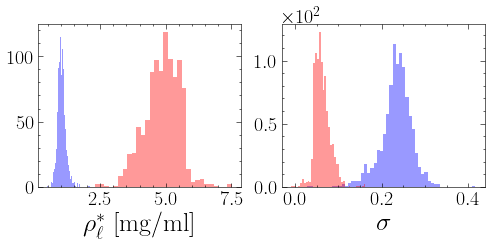

In [235]:
# Equilibrium vapour pressure
peq_FUS_estimate=np.mean(peqFUS)
peq_DDX_estimate=np.mean(peqDDX)

# Equilibrium density of the dilute phase FUS
LD_FUS=peqFUS*ml_nm3*weightFUS/kT; #mg/ml
LD_FUS_estimate=np.mean(LD_FUS)
LD_FUS_err=1.96*np.std(LD_FUS) # 95% confidence interval
# Equilibrium density of the dilute phase NDDX4
LD_DDX=peqDDX*ml_nm3*weightDDX/kT; #mg/ml
LD_DDX_estimate=np.mean(LD_DDX)
LD_DDX_err=1.96*np.std(LD_DDX) # 95% confidence interval
    
fig,ax = plt.subplots(1,2,figsize=(8,3))
ax[0].hist(LD_FUS, bins = 'auto',alpha=0.4,color='blue')
ax[0].hist(LD_DDX, bins = 'auto',alpha=0.4,color='red')
ax[0].set_xlabel('$\\rho_\ell^*$ [mg/ml]',fontsize=26)
plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
plt.savefig('panel_2_parameters', dpi=600, bbox_inches='tight');

print('The equilibrium density of the FUS dilute phase is:',LD_FUS_estimate,'+/-',LD_FUS_err,'mg/ml')
print('The equilibrium density of the NDDX4 dilute phase is:',LD_DDX_estimate,'+/-',LD_DDX_err,'mg/ml')

sigma_FUS_estimate=np.mean(sigmaFUS)
sigma_FUS_err=1.96*np.std(sigmaFUS) # 95% confidence interval
sigma_DDX_estimate=np.mean(sigmaDDX)
sigma_DDX_err=1.96*np.std(sigmaDDX) # 95% confidence interval
    
ax[1].hist(sigmaFUS, bins = 'auto',alpha=0.4,color='blue')
ax[1].hist(sigmaDDX, bins = 'auto',alpha=0.4,color='red')
ax[1].set_xlabel('$\\sigma$',fontsize=26)
plt.ticklabel_format(axis='both', style='sci', scilimits=(-2,2))
plt.savefig('Fitted_params', dpi=600, bbox_inches='tight');

print('The surface tension of FUS is:',sigma_FUS_estimate,'+/-',sigma_FUS_err)
print('The surface tension of NDDX4 is:',sigma_DDX_estimate,'+/-',sigma_DDX_err)

In [217]:
dataFUS.Ntot

0     50
1     69
2     98
3     84
4    118
5    169
6    133
7    187
8    268
Name: Ntot, dtype: int64

In [219]:
VFUS

0     64000
1    125000
2    125000
3    216000
4    216000
5    216000
6    343000
7    343000
8    343000
Name: L, dtype: int64

In [222]:
dataFUS.Nss

0     42
1     55
2     86
3     63
4    101
5    153
6    103
7    158
8    243
Name: Nss, dtype: int64

In [223]:
#vlFUS=np.power(0.0185,-1); #nm3 from FUS density from radial density profile
#vlDDX=np.power(0.0085,-1); #nm3 from NDDX4 density from radial density profile

54.054054054054056

In [236]:
for SIM in np.arange(0,NsimulationsFUS):
    p1=kT*(dataFUS.Ntot[SIM]-dataFUS.Nss[SIM])/(VFUS[SIM]-dataFUS.Nss[SIM]*vlFUS)
    rho1=(dataFUS.Ntot[SIM]-dataFUS.Nss[SIM])/(VFUS[SIM]-dataFUS.Nss[SIM]/0.0185)
    print(rho1)

0.00012959719789842382
0.00011472868217054263
9.970806198068719e-05
9.877955758962624e-05
8.074454428754814e-05
7.702315899037211e-05
8.890668802563076e-05
8.67070707070707e-05
7.578861122490783e-05


In [232]:
for SIM in np.arange(0,NsimulationsDDX):
    p1=kT*(dataDDX.Ntot[SIM]-dataDDX.Nss[SIM])/(VDDX[SIM]-dataDDX.Nss[SIM]*vlDDX)
    rho1=(dataDDX.Ntot[SIM]-dataDDX.Nss[SIM])/(VDDX[SIM]-dataDDX.Nss[SIM]/0.0085)
    print(p1/rho1)

2.49
2.4899999999999998
2.49
2.49
2.4899999999999998
2.49
2.49
2.49


In [233]:
NsimulationsDDX

8

[1.94531250e-03 1.94348470e-03 1.94165674e-03 1.93982864e-03
 1.93800038e-03 1.93617197e-03 1.93434341e-03 1.93251470e-03
 1.93068584e-03 1.92885682e-03 1.92702766e-03 1.92519834e-03
 1.92336887e-03 1.92153925e-03 1.91970947e-03 1.91787955e-03
 1.91604947e-03 1.91421924e-03 1.91238886e-03 1.91055833e-03
 1.90872765e-03 1.90689681e-03 1.90506583e-03 1.90323469e-03
 1.90140340e-03 1.89957195e-03 1.89774036e-03 1.89590861e-03
 1.89407671e-03 1.89224466e-03 1.89041246e-03 1.88858011e-03
 1.88674760e-03 1.88491494e-03 1.88308213e-03 1.88124917e-03
 1.87941605e-03 1.87758279e-03 1.87574937e-03 1.87391580e-03
 1.87208207e-03 1.87024820e-03 1.86841417e-03 1.86657999e-03
 1.86474566e-03 1.86291117e-03 1.86107654e-03 1.85924175e-03
 1.85740681e-03 1.85557171e-03 1.85373647e-03 1.85190107e-03
 1.85006552e-03 1.84822982e-03 1.84639396e-03 1.84455795e-03
 1.84272179e-03 1.84088548e-03 1.83904901e-03 1.83721239e-03
 1.83537562e-03 1.83353870e-03 1.83170163e-03 1.82986440e-03
 1.82802702e-03 1.826189

[1.37448000e-03 1.37316450e-03 1.37184893e-03 1.37053328e-03
 1.36921755e-03 1.36790174e-03 1.36658586e-03 1.36526989e-03
 1.36395385e-03 1.36263774e-03 1.36132154e-03 1.36000527e-03
 1.35868892e-03 1.35737250e-03 1.35605599e-03 1.35473941e-03
 1.35342275e-03 1.35210601e-03 1.35078920e-03 1.34947231e-03
 1.34815534e-03 1.34683829e-03 1.34552116e-03 1.34420396e-03
 1.34288668e-03 1.34156932e-03 1.34025189e-03 1.33893438e-03
 1.33761679e-03 1.33629912e-03 1.33498137e-03 1.33366355e-03
 1.33234565e-03 1.33102767e-03 1.32970961e-03 1.32839148e-03
 1.32707327e-03 1.32575498e-03 1.32443661e-03 1.32311816e-03
 1.32179964e-03 1.32048104e-03 1.31916236e-03 1.31784361e-03
 1.31652477e-03 1.31520586e-03 1.31388687e-03 1.31256781e-03
 1.31124866e-03 1.30992944e-03 1.30861014e-03 1.30729076e-03
 1.30597131e-03 1.30465177e-03 1.30333216e-03 1.30201247e-03
 1.30069271e-03 1.29937286e-03 1.29805294e-03 1.29673294e-03
 1.29541286e-03 1.29409271e-03 1.29277247e-03 1.29145216e-03
 1.29013177e-03 1.288811

(0.0, 80.0)

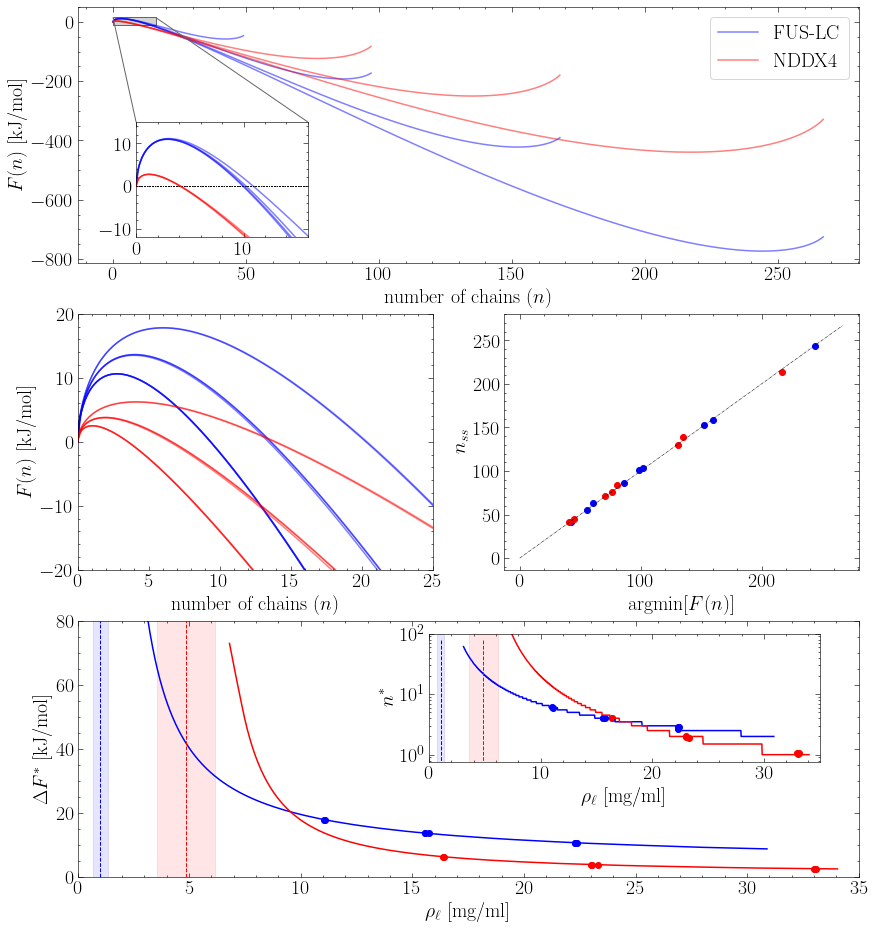

In [213]:
## Define FES confined and macroscopic
FES_confined=lambda nn, N, peq, sigma, p0, p1, vl, r, kT, : -nn*kT*np.log(p1/peq)+sigma*4*np.pi*np.power(r,2)+nn*(kT-vl*peq)+N*kT*np.log(p1/p0);
FES_macro=lambda nn, peq, sigma, p0, r, kT, : -nn*kT*np.log(p0/peq)+sigma*4*np.pi*np.power(r,2);

## Plot sub-figures setup
fig = plt.figure(figsize=(14, 16))
sub1 = fig.add_subplot(3,2,(1,2))
sub2 = fig.add_subplot(3,2,3)
sub3 = fig.add_subplot(3,2,4)
sub4 = fig.add_subplot(3,2,(5,6))

## labels
sub1.set_xlabel('number of chains ($n$)')
sub1.set_ylabel('$F(n)$ [kJ/mol]')
sub2.set_xlabel('number of chains ($n$)')
sub2.set_ylabel('$F(n)$ [kJ/mol]')
sub3.set_xlabel('argmin$[F(n)]$')
sub3.set_ylabel('$n_{ss}$')
sub4.set_xlabel('$\\rho_\ell$ [mg/ml]')
sub4.set_ylabel('$\\Delta{F}^*$ [kJ/mol]')

#### range
sub4.set_xlim([0,35])

## insets
ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(sub1, [0.075,0.1,0.22,0.45])
ax2.set_axes_locator(ip)
# Mark the region corresponding to the inset axes on ax1 and draw lines.
ax2.set_xlim([0,16])
ax2.set_ylim([-12,15]) 
mark_inset(sub1, ax2, loc1=1, loc2=2, fc="lightgray", ec='0.4')

ax3 = plt.axes([1,1,1,1])
ip2 = InsetPosition(sub4, [0.45,0.45,0.5,0.5])
ax3.set_axes_locator(ip2)
ax3.set_xlabel('$\\rho_\ell$ [mg/ml]')
ax3.set_ylabel('$n^*$')

#Initialise vectors for macroscopic quantitites
argminF_FUS=np.zeros(NsimulationsFUS) #Steady state nucleus size predicted by the MLD model
argminF_DDX=np.zeros(NsimulationsDDX)
argmaxF_FUS=np.zeros(NsimulationsFUS) #Critical nucleus size
argmaxF_DDX=np.zeros(NsimulationsDDX)
DF_FUS=np.zeros(NsimulationsFUS)      #Nucleation barrier
DF_DDX=np.zeros(NsimulationsDDX)

#compute FUS Free Energies (and plot panel 1)
for SIM in np.arange(0,NsimulationsFUS):
    #Compute FES given the fitted parameters
    nn=np.linspace(0, dataFUS.Ntot[SIM]-1, num=1000)
    p0=p0FUS[SIM]
    p1=kT*(dataFUS.Ntot[SIM]-nn)/(VFUS[SIM]-nn*vlFUS)
    print(p1)
    r=np.power(3*nn*vlFUS/4/np.pi,1/3);
    FES=FES_confined(nn,dataFUS.Ntot[SIM],peq_FUS_estimate,sigma_FUS_estimate,p0,p1,vlFUS,r,kT)   
    FESm=FES_macro(nn, peq_FUS_estimate, sigma_FUS_estimate, p0, r, kT)
    #only plot one nominal density, different system sizes
    if SIM==0 or SIM==2 or SIM==5 or SIM==8: 
        lineFUS,=sub1.plot(nn,FES,'b',alpha=0.5,label='FUS-LC')
        ax2.plot(nn,FES,'b',alpha=0.5)
    ax2.axhline(y=0,lw=1,ls=":",color="black")
    #plot all macroscopic FES   
    #sub1.axhline(y=0,lw=1,ls=":",color="black")
    sub2.plot(nn,FESm,'b',alpha=0.5)
    sub2.set_ylim([-20,20])
    sub2.set_xlim([0,25])
    #compute steady state droplet size, critical nucleus size, and nucleation barrier
    argminF_FUS[SIM]=nn[FES==np.min(FES)]
    argmaxF_FUS[SIM]=nn[FESm==np.max(FESm)]
    DF_FUS[SIM]=np.max(FESm)
    #plot stuff in subpanels
    sub3.scatter(argminF_FUS[SIM],dataFUS.Nss[SIM],color='blue') 
    sub4.scatter(p0*ml_nm3*weightFUS/kT,DF_FUS[SIM],color='blue')
    ax3.scatter(p0*ml_nm3*weightFUS/kT,argmaxF_FUS[SIM],color='blue')
    
#NDDX4 Free Energies (and plot panel 1)    
for SIM in np.arange(0,NsimulationsDDX):
    #Compute FES given the fitted parameters
    nn=np.linspace(0, dataDDX.Ntot[SIM]-1, num=1000)
    p0=p0DDX[SIM]
    p1=kT*(dataDDX.Ntot[SIM]-nn)/(VDDX[SIM]-nn*vlDDX)
    r=np.power(3*nn*vlDDX/4/np.pi,1/3);
    FES=FES_confined(nn,dataDDX.Ntot[SIM],peq_DDX_estimate,sigma_DDX_estimate,p0,p1,vlDDX,r,kT)   
    FESm=FES_macro(nn, peq_DDX_estimate, sigma_DDX_estimate, p0, r, kT)
    #only plot one nominal density, different system sizes
    if SIM==1 or SIM==4 or SIM==7: 
        lineDDX,=sub1.plot(nn,FES,'r',alpha=0.5,label='NDDX4')
        ax2.plot(nn,FES,'r',alpha=0.5,label='NDDX4')
    #plot all macroscopic FES
    sub2.plot(nn,FESm,'r',alpha=0.5)
    sub2.set_ylim([-20,20])
    sub2.set_xlim([0,25])
    #compute steady state droplet size, critical nucleus size, and nucleation barrier
    argminF_DDX[SIM]=nn[FES==np.min(FES)]
    argmaxF_DDX[SIM]=nn[FESm==np.max(FESm)]
    DF_DDX[SIM]=np.max(FESm)
    #plot stuff in subpanels
    sub3.scatter(argminF_DDX[SIM],dataDDX.Nss[SIM],color='red')
    sub4.scatter(p0*ml_nm3*weightDDX/kT,DF_DDX[SIM],color='red')
    ax3.scatter(p0*ml_nm3*weightDDX/kT,argmaxF_DDX[SIM],color='red')

#Add legend in panel 1
sub1.legend([lineFUS,lineDDX], ['FUS-LC','NDDX4'])
#Add parity line in panel 3
sub3.plot(nn,nn,'k-.',LineWidth=0.5)    

#Compute nucleation barrier and critical nucleus size as a function of system size from the model
#FUS
nn=np.linspace(0, 500, num=1000)
P0=np.linspace(peq_FUS_estimate*3,peq_FUS_estimate*30,1000)
DFFUS=np.zeros(np.shape(P0))
ncritFUS=np.zeros(np.shape(P0))
for i in np.arange(0,np.shape(P0)[0]):
    p0=P0[i]
    r=np.power(3*nn*vlFUS/4/np.pi,1/3);
    FESm=FES_macro(nn, peq_FUS_estimate, sigma_FUS_estimate, p0, r, kT)
    DFFUS[i]=np.max(FESm)
    ncritFUS[i]=nn[FESm==np.max(FESm)]
sub4.plot(P0*ml_nm3*weightFUS/kT,DFFUS,'b')
ax3.plot(P0*ml_nm3*weightFUS/kT,ncritFUS,'b')

#DDX4 
P0=np.linspace(peq_DDX_estimate*1.4,peq_DDX_estimate*7,1000)
DFDDX=np.zeros(np.shape(P0))
ncritDDX=np.zeros(np.shape(P0))
for i in np.arange(0,np.shape(P0)[0]):
    p0=P0[i]
    r=np.power(3*nn*vlDDX/4/np.pi,1/3);
    FESm=FES_macro(nn, peq_DDX_estimate, sigma_DDX_estimate, p0, r, kT)
    DFDDX[i]=np.max(FESm[1:200])
    ncritDDX[i]=nn[FESm==np.max(FESm)]
sub4.plot(P0*ml_nm3*weightDDX/kT,DFDDX,'r')
ax3.plot(P0*ml_nm3*weightDDX/kT,ncritDDX,'r')

#plot critical nucleus sizes in inset
ax3.plot([LD_FUS_estimate, LD_FUS_estimate],[0, 80],'--b',Linewidth=1.0)
ax3.plot([LD_DDX_estimate, LD_DDX_estimate],[0, 80],'--r',Linewidth=1.0)
ax3.add_patch(Rectangle((LD_DDX_estimate-LD_DDX_err, 0), 2*LD_DDX_err, 100,color='red',alpha=0.1))
ax3.add_patch(Rectangle((LD_FUS_estimate-LD_FUS_err, 0), 2*LD_FUS_err, 100,color='blue',alpha=0.1))
ax3.set_xlim([0,35])
ax3.set_yscale("log")
ax3.set_ylim([0,100])
#ax3.set_yticks([0, 20, 40, 60, 80])

#plot equilibrium density estimate with confidence interval
sub4.plot([LD_FUS_estimate, LD_FUS_estimate],[0, 80],'--b',Linewidth=1.0)
sub4.plot([LD_DDX_estimate, LD_DDX_estimate],[0, 80],'--r',Linewidth=1.0)
sub4.add_patch(Rectangle((LD_DDX_estimate-LD_DDX_err, 0), 2*LD_DDX_err, 100,color='red',alpha=0.1))
sub4.add_patch(Rectangle((LD_FUS_estimate-LD_FUS_err, 0), 2*LD_FUS_err, 100,color='blue',alpha=0.1))

sub4.set_ylim([0,80])

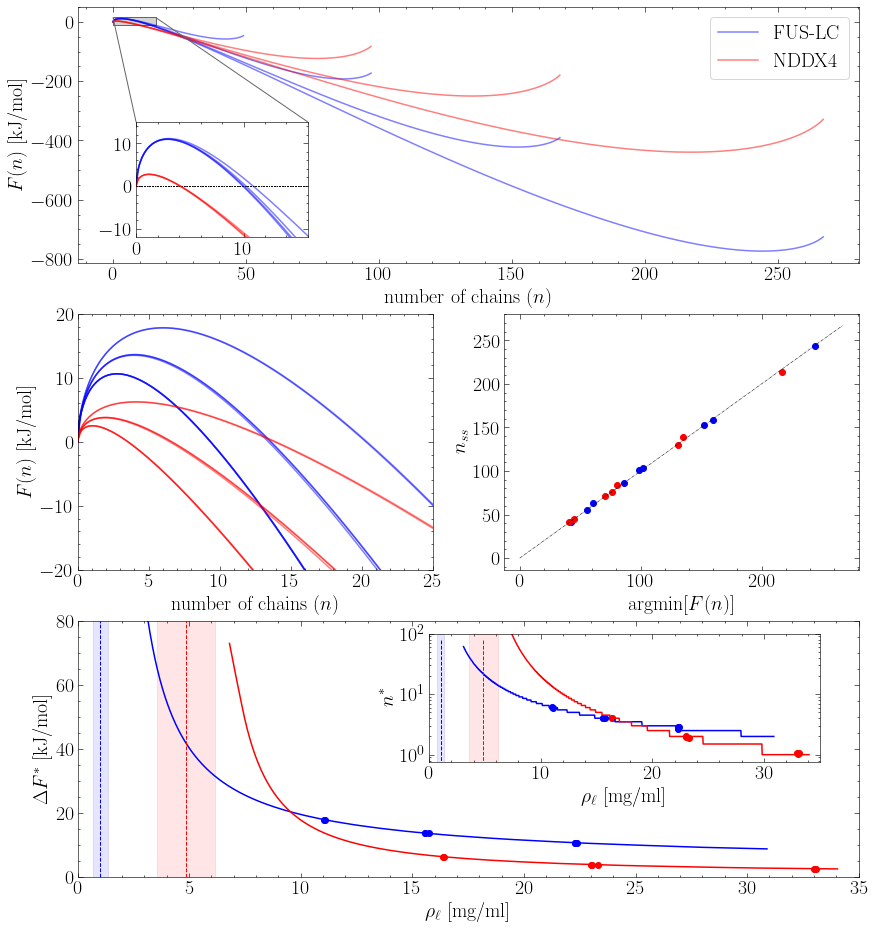

In [11]:
## Define FES confined and macroscopic
FES_confined=lambda nn, N, peq, sigma, p0, p1, vl, r, kT, : -nn*kT*np.log(p1/peq)+sigma*4*np.pi*np.power(r,2)+nn*(kT-vl*peq)+N*kT*np.log(p1/p0);
FES_macro=lambda nn, peq, sigma, p0, r, kT, : -nn*kT*np.log(p0/peq)+sigma*4*np.pi*np.power(r,2);

## Plot sub-figures setup
fig = plt.figure(figsize=(14, 16))
sub1 = fig.add_subplot(3,2,(1,2))
sub2 = fig.add_subplot(3,2,3)
sub3 = fig.add_subplot(3,2,4)
sub4 = fig.add_subplot(3,2,(5,6))

## labels
sub1.set_xlabel('number of chains ($n$)')
sub1.set_ylabel('$F(n)$ [kJ/mol]')
sub2.set_xlabel('number of chains ($n$)')
sub2.set_ylabel('$F(n)$ [kJ/mol]')
sub3.set_xlabel('argmin$[F(n)]$')
sub3.set_ylabel('$n_{ss}$')
sub4.set_xlabel('$\\rho_\ell$ [mg/ml]')
sub4.set_ylabel('$\\Delta{F}^*$ [kJ/mol]')

#### range
sub4.set_xlim([0,35])

## insets
ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(sub1, [0.075,0.1,0.22,0.45])
ax2.set_axes_locator(ip)
# Mark the region corresponding to the inset axes on ax1 and draw lines.
ax2.set_xlim([0,16])
ax2.set_ylim([-12,15]) 
mark_inset(sub1, ax2, loc1=1, loc2=2, fc="lightgray", ec='0.4')

ax3 = plt.axes([1,1,1,1])
ip2 = InsetPosition(sub4, [0.45,0.45,0.5,0.5])
ax3.set_axes_locator(ip2)
ax3.set_xlabel('$\\rho_\ell$ [mg/ml]')
ax3.set_ylabel('$n^*$')

#Initialise vectors for macroscopic quantitites
argminF_FUS=np.zeros(NsimulationsFUS) #Steady state nucleus size predicted by the MLD model
argminF_DDX=np.zeros(NsimulationsDDX)
argmaxF_FUS=np.zeros(NsimulationsFUS) #Critical nucleus size
argmaxF_DDX=np.zeros(NsimulationsDDX)
DF_FUS=np.zeros(NsimulationsFUS)      #Nucleation barrier
DF_DDX=np.zeros(NsimulationsDDX)

#compute FUS Free Energies (and plot panel 1)
for SIM in np.arange(0,NsimulationsFUS):
    #Compute FES given the fitted parameters
    nn=np.linspace(0, dataFUS.Ntot[SIM]-1, num=1000)
    p0=p0FUS[SIM]
    p1=kT*(dataFUS.Ntot[SIM]-nn)/(VFUS[SIM]-nn*vlFUS)
    r=np.power(3*nn*vlFUS/4/np.pi,1/3);
    FES=FES_confined(nn,dataFUS.Ntot[SIM],peq_FUS_estimate,sigma_FUS_estimate,p0,p1,vlFUS,r,kT)   
    FESm=FES_macro(nn, peq_FUS_estimate, sigma_FUS_estimate, p0, r, kT)
    #only plot one nominal density, different system sizes
    if SIM==0 or SIM==2 or SIM==5 or SIM==8: 
        lineFUS,=sub1.plot(nn,FES,'b',alpha=0.5,label='FUS-LC')
        ax2.plot(nn,FES,'b',alpha=0.5)
    ax2.axhline(y=0,lw=1,ls=":",color="black")
    #plot all macroscopic FES   
    #sub1.axhline(y=0,lw=1,ls=":",color="black")
    sub2.plot(nn,FESm,'b',alpha=0.5)
    sub2.set_ylim([-20,20])
    sub2.set_xlim([0,25])
    #compute steady state droplet size, critical nucleus size, and nucleation barrier
    argminF_FUS[SIM]=nn[FES==np.min(FES)]
    argmaxF_FUS[SIM]=nn[FESm==np.max(FESm)]
    DF_FUS[SIM]=np.max(FESm)
    #plot stuff in subpanels
    sub3.scatter(argminF_FUS[SIM],dataFUS.Nss[SIM],color='blue') 
    sub4.scatter(p0*ml_nm3*weightFUS/kT,DF_FUS[SIM],color='blue')
    ax3.scatter(p0*ml_nm3*weightFUS/kT,argmaxF_FUS[SIM],color='blue')
    
#NDDX4 Free Energies (and plot panel 1)    
for SIM in np.arange(0,NsimulationsDDX):
    #Compute FES given the fitted parameters
    nn=np.linspace(0, dataDDX.Ntot[SIM]-1, num=1000)
    p0=p0DDX[SIM]
    p1=kT*(dataDDX.Ntot[SIM]-nn)/(VDDX[SIM]-nn*vlDDX)
    r=np.power(3*nn*vlDDX/4/np.pi,1/3);
    FES=FES_confined(nn,dataDDX.Ntot[SIM],peq_DDX_estimate,sigma_DDX_estimate,p0,p1,vlDDX,r,kT)   
    FESm=FES_macro(nn, peq_DDX_estimate, sigma_DDX_estimate, p0, r, kT)
    #only plot one nominal density, different system sizes
    if SIM==1 or SIM==4 or SIM==7: 
        lineDDX,=sub1.plot(nn,FES,'r',alpha=0.5,label='NDDX4')
        ax2.plot(nn,FES,'r',alpha=0.5,label='NDDX4')
    #plot all macroscopic FES
    sub2.plot(nn,FESm,'r',alpha=0.5)
    sub2.set_ylim([-20,20])
    sub2.set_xlim([0,25])
    #compute steady state droplet size, critical nucleus size, and nucleation barrier
    argminF_DDX[SIM]=nn[FES==np.min(FES)]
    argmaxF_DDX[SIM]=nn[FESm==np.max(FESm)]
    DF_DDX[SIM]=np.max(FESm)
    #plot stuff in subpanels
    sub3.scatter(argminF_DDX[SIM],dataDDX.Nss[SIM],color='red')
    sub4.scatter(p0*ml_nm3*weightDDX/kT,DF_DDX[SIM],color='red')
    ax3.scatter(p0*ml_nm3*weightDDX/kT,argmaxF_DDX[SIM],color='red')

#Add legend in panel 1
sub1.legend([lineFUS,lineDDX], ['FUS-LC','NDDX4'])
#Add parity line in panel 3
sub3.plot(nn,nn,'k-.',LineWidth=0.5)    

#Compute nucleation barrier and critical nucleus size as a function of system size from the model
#FUS
nn=np.linspace(0, 500, num=1000)
P0=np.linspace(peq_FUS_estimate*3,peq_FUS_estimate*30,1000)
DFFUS=np.zeros(np.shape(P0))
ncritFUS=np.zeros(np.shape(P0))
for i in np.arange(0,np.shape(P0)[0]):
    p0=P0[i]
    r=np.power(3*nn*vlFUS/4/np.pi,1/3);
    FESm=FES_macro(nn, peq_FUS_estimate, sigma_FUS_estimate, p0, r, kT)
    DFFUS[i]=np.max(FESm)
    ncritFUS[i]=nn[FESm==np.max(FESm)]
sub4.plot(P0*ml_nm3*weightFUS/kT,DFFUS,'b')
ax3.plot(P0*ml_nm3*weightFUS/kT,ncritFUS,'b')

#DDX4 
P0=np.linspace(peq_DDX_estimate*1.4,peq_DDX_estimate*7,1000)
DFDDX=np.zeros(np.shape(P0))
ncritDDX=np.zeros(np.shape(P0))
for i in np.arange(0,np.shape(P0)[0]):
    p0=P0[i]
    r=np.power(3*nn*vlDDX/4/np.pi,1/3);
    FESm=FES_macro(nn, peq_DDX_estimate, sigma_DDX_estimate, p0, r, kT)
    DFDDX[i]=np.max(FESm[1:200])
    ncritDDX[i]=nn[FESm==np.max(FESm)]
sub4.plot(P0*ml_nm3*weightDDX/kT,DFDDX,'r')
ax3.plot(P0*ml_nm3*weightDDX/kT,ncritDDX,'r')

#plot critical nucleus sizes in inset
ax3.plot([LD_FUS_estimate, LD_FUS_estimate],[0, 80],'--b',Linewidth=1.0)
ax3.plot([LD_DDX_estimate, LD_DDX_estimate],[0, 80],'--r',Linewidth=1.0)
ax3.add_patch(Rectangle((LD_DDX_estimate-LD_DDX_err, 0), 2*LD_DDX_err, 100,color='red',alpha=0.1))
ax3.add_patch(Rectangle((LD_FUS_estimate-LD_FUS_err, 0), 2*LD_FUS_err, 100,color='blue',alpha=0.1))
ax3.set_xlim([0,35])
ax3.set_yscale("log")
ax3.set_ylim([0,100])
#ax3.set_yticks([0, 20, 40, 60, 80])

#plot equilibrium density estimate with confidence interval
sub4.plot([LD_FUS_estimate, LD_FUS_estimate],[0, 80],'--b',Linewidth=1.0)
sub4.plot([LD_DDX_estimate, LD_DDX_estimate],[0, 80],'--r',Linewidth=1.0)
sub4.add_patch(Rectangle((LD_DDX_estimate-LD_DDX_err, 0), 2*LD_DDX_err, 100,color='red',alpha=0.1))
sub4.add_patch(Rectangle((LD_FUS_estimate-LD_FUS_err, 0), 2*LD_FUS_err, 100,color='blue',alpha=0.1))

sub4.set_ylim([0,80])

# Save it! 
plt.savefig('FES', dpi=600, bbox_inches='tight');

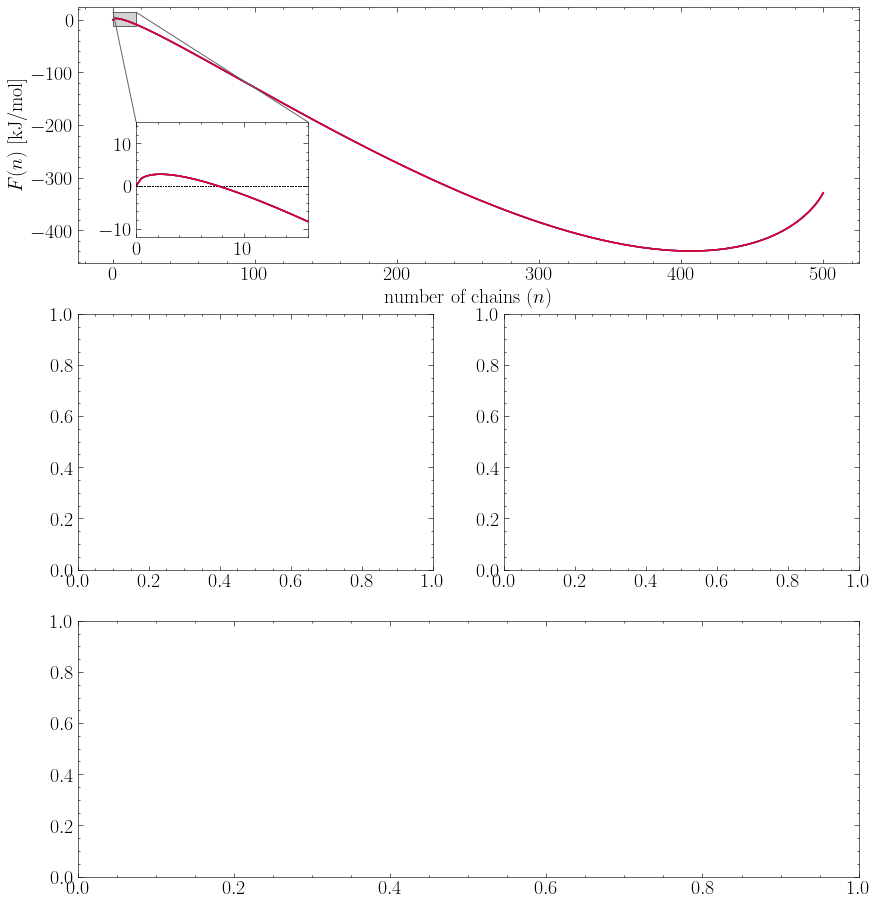

In [63]:
FES_confined=lambda nn, N, peq, sigma, p0, p1, vl, r, kT, : -nn*kT*np.log(p1/peq)+sigma*4*np.pi*np.power(r,2)+nn*(kT-vl*peq)+N*kT*np.log(p1/p0);
FES_macro=lambda nn, peq, sigma, p0, r, kT, : -nn*kT*np.log(p0/peq)+sigma*4*np.pi*np.power(r,2);

fig = plt.figure(figsize=(14, 16))
sub0 = fig.add_subplot(3,2,(1,2))
sub2 = fig.add_subplot(3,2,3)
sub3 = fig.add_subplot(3,2,4)
sub4 = fig.add_subplot(3,2,(5,6))

sub0.set_xlabel('number of chains ($n$)')
sub0.set_ylabel('$F(n)$ [kJ/mol]')


## insets
ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(sub0, [0.075,0.1,0.22,0.45])
ax2.set_axes_locator(ip)
ax2.set_xlim([0,16])
ax2.set_ylim([-12,15]) 
mark_inset(sub0, ax2, loc1=1, loc2=2, fc="lightgray", ec='0.4')

#compute FUS Free Energies (and plot panel 1)
for SIM in np.arange(0,NsimulationsFUS):
    if SIM==0 or SIM==2 or SIM==5 or SIM==8: 
        lineFUS,=sub0.plot(nn,FES,'b',alpha=0.5,label='FUS-LC')
        ax2.plot(nn,FES,'b',alpha=0.5)
    ax2.axhline(y=0,lw=1,ls=":",color="black")
    
#NDDX4 Free Energies (and plot panel 1)    
for SIM in np.arange(0,NsimulationsDDX):
    if SIM==1 or SIM==4 or SIM==7: 
        lineDDX,=sub0.plot(nn,FES,'r',alpha=0.5,label='NDDX4')
        ax2.plot(nn,FES,'r',alpha=0.5,label='NDDX4')
#Add legend in panel 1
#sub0.legend([lineFUS,lineDDX], ['FUS-LC','NDDX4'])

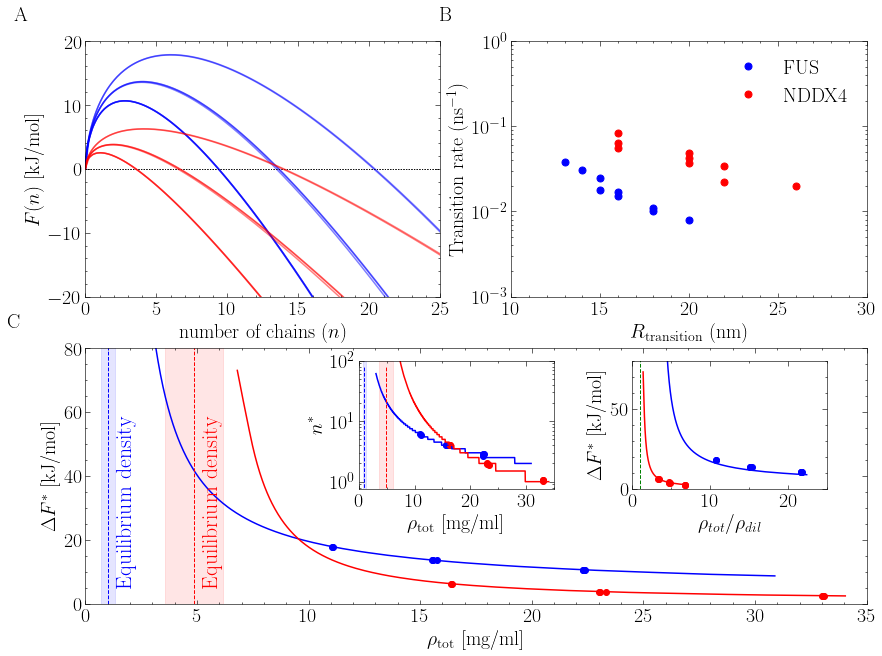

In [143]:
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator
## Define FES confined and macroscopic
FES_confined=lambda nn, N, peq, sigma, p0, p1, vl, r, kT, : -nn*kT*np.log(p1/peq)+sigma*4*np.pi*np.power(r,2)+nn*(kT-vl*peq)+N*kT*np.log(p1/p0);
FES_macro=lambda nn, peq, sigma, p0, r, kT, : -nn*kT*np.log(p0/peq)+sigma*4*np.pi*np.power(r,2);

## Plot sub-figures setup
fig = plt.figure(figsize=(14, 16))
sub1 = fig.add_subplot(3,2,1)
sub2 = fig.add_subplot(3,2,2)
sub3 = fig.add_subplot(3,2,(3,4))

## labels
sub1.set_xlabel('number of chains ($n$)')
sub1.set_ylabel('$F(n)$ [kJ/mol]')
sub2.set_xlabel(r'$R_\mathrm{transition}$ (nm)')
sub2.set_ylabel('Transition rate (ns$^{-1}$)')
sub3.set_xlabel('$\\rho_d^\circ$ [mg/ml]')
sub3.set_ylabel('$\\Delta{F}^*$ [kJ/mol]')

## insets
ax3 = plt.axes([1,1,1,1])
ip2 = InsetPosition(sub3, [0.35,0.45,0.25,0.5])
ax3.set_axes_locator(ip2)
ax3.set_xlabel('$\\rho_d^\circ$ [mg/ml]')
ax3.set_ylabel('$n^*$')

ax4 = plt.axes([1,1,1,1])
ip2 = InsetPosition(sub3, [0.7,0.45,0.25,0.5])
ax4.set_axes_locator(ip2)
ax4.set_xlabel('$\\rho_d^\circ/\\rho_d^*$')
ax4.set_ylabel('$\\Delta{F}^*$ [kJ/mol]')

## label 
sub1.text(-0.2, 1.10, 'A', transform=sub1.transAxes,verticalalignment='center')
sub2.text(-0.2, 1.10, 'B', transform=sub2.transAxes,verticalalignment='center')
sub3.text(-0.1, 1.10, 'C', transform=sub3.transAxes,verticalalignment='center')

sub3.set_xlim([0,35])
ax3.set_xlim([0,35])
ax4.set_xlim([0,25])
#######################################################################
sub2.plot(MFPT_FUS[1],MFPT_FUS[0],label = "FUS",marker="o",markersize=7,color='blue',linestyle=None,linewidth=0)
sub2.plot(MFPT_DDX4[1],MFPT_DDX4[0],label = "NDDX4",marker="o",markersize=7,color='red',linestyle=None,linewidth=0)
sub2.xaxis.set_minor_locator(AutoMinorLocator(5))
sub2.yaxis.set_minor_locator(AutoMinorLocator(5))
#sub2.grid(which="major")
sub2.set_xlim(10,30)
sub2.set_ylim(0.001,1)
sub2.set_yscale('log')
lgd=sub2.legend(loc='best', frameon=False, ncol=1)
#######################################################################
#compute FUS Free Energies (and plot panel 1)
for SIM in np.arange(0,NsimulationsFUS):
    #Compute FES given the fitted parameters
    nn=np.linspace(0, dataFUS.Ntot[SIM]-1, num=1000)
    p0=p0FUS[SIM]
    p1=kT*(dataFUS.Ntot[SIM]-nn)/(VFUS[SIM]-nn*vlFUS)
    r=np.power(3*nn*vlFUS/4/np.pi,1/3);
    FES=FES_confined(nn,dataFUS.Ntot[SIM],peq_FUS_estimate,sigma_FUS_estimate,p0,p1,vlFUS,r,kT)   
    FESm=FES_macro(nn, peq_FUS_estimate, sigma_FUS_estimate, p0, r, kT)
    #only plot one nominal density, different system sizes
    #if SIM==0 or SIM==2 or SIM==5 or SIM==8: 
    #    lineFUS,=sub1.plot(nn,FES,'b',alpha=0.5,label='FUS')
    #    ax2.plot(nn,FES,'b',alpha=0.5)
    #plot all macroscopic FES    
    sub1.plot(nn,FESm,'b',alpha=0.5)
    sub1.axhline(0,color="black",alpha=0.3,lw=1.0,ls=":")
    sub1.set_ylim([-20,20])
    sub1.set_xlim([0,25])
    #compute steady state droplet size, critical nucleus size, and nucleation barrier
    argminF_FUS[SIM]=nn[FES==np.min(FES)]
    argmaxF_FUS[SIM]=nn[FESm==np.max(FESm)]
    DF_FUS[SIM]=np.max(FESm)
    #plot stuff in subpanels
    sub3.scatter(p0*ml_nm3*weightFUS/kT,DF_FUS[SIM],color='blue')
    ax3.scatter(p0*ml_nm3*weightFUS/kT,argmaxF_FUS[SIM],color='blue')
    ax4.scatter(p0*ml_nm3*weightFUS/kT/LD_FUS_estimate,DF_FUS[SIM],color='blue')

#NDDX4 Free Energies (and plot panel 1)    
for SIM in np.arange(0,NsimulationsDDX):
    #Compute FES given the fitted parameters
    nn=np.linspace(0, dataDDX.Ntot[SIM]-1, num=1000)
    p0=p0DDX[SIM]
    p1=kT*(dataDDX.Ntot[SIM]-nn)/(VDDX[SIM]-nn*vlDDX)
    r=np.power(3*nn*vlDDX/4/np.pi,1/3);
    FES=FES_confined(nn,dataDDX.Ntot[SIM],peq_DDX_estimate,sigma_DDX_estimate,p0,p1,vlDDX,r,kT)   
    FESm=FES_macro(nn, peq_DDX_estimate, sigma_DDX_estimate, p0, r, kT)
    #only plot one nominal density, different system sizes
    #if SIM==1 or SIM==4 or SIM==7: 
    #    lineDDX,=sub1.plot(nn,FES,'r',alpha=0.5,label='NDDX4')
    #    ax2.plot(nn,FES,'r',alpha=0.5,label='NDDX4')
    #plot all macroscopic FES
    sub1.plot(nn,FESm,'r',alpha=0.5)
    sub1.set_ylim([-20,20])
    sub1.set_xlim([0,25])
    #compute steady state droplet size, critical nucleus size, and nucleation barrier
    argminF_DDX[SIM]=nn[FES==np.min(FES)]
    argmaxF_DDX[SIM]=nn[FESm==np.max(FESm)]
    DF_DDX[SIM]=np.max(FESm)
    #plot stuff in subpanels
    sub3.scatter(p0*ml_nm3*weightDDX/kT,DF_DDX[SIM],color='red')
    ax3.scatter(p0*ml_nm3*weightDDX/kT,argmaxF_DDX[SIM],color='red') 
    ax4.scatter(p0*ml_nm3*weightDDX/kT/LD_DDX_estimate,DF_DDX[SIM],color='red')
    
#Compute nucleation barrier and critical nucleus size as a function of system size from the model
#FUS
nn=np.linspace(0, 500, num=1000)
P0=np.linspace(peq_FUS_estimate*3,peq_FUS_estimate*30,1000)
DFFUS=np.zeros(np.shape(P0))
ncritFUS=np.zeros(np.shape(P0))
for i in np.arange(0,np.shape(P0)[0]):
    p0=P0[i]
    r=np.power(3*nn*vlFUS/4/np.pi,1/3);
    FESm=FES_macro(nn, peq_FUS_estimate, sigma_FUS_estimate, p0, r, kT)
    DFFUS[i]=np.max(FESm)
    ncritFUS[i]=nn[FESm==np.max(FESm)]
sub3.plot(P0*ml_nm3*weightFUS/kT,DFFUS,'b')
ax3.plot(P0*ml_nm3*weightFUS/kT,ncritFUS,'b')
#DDX4 
P0=np.linspace(peq_DDX_estimate*1.4,peq_DDX_estimate*7,1000)
DFDDX=np.zeros(np.shape(P0))
ncritDDX=np.zeros(np.shape(P0))
for i in np.arange(0,np.shape(P0)[0]):
    p0=P0[i]
    r=np.power(3*nn*vlDDX/4/np.pi,1/3);
    FESm=FES_macro(nn, peq_DDX_estimate, sigma_DDX_estimate, p0, r, kT)
    DFDDX[i]=np.max(FESm[1:200])
    ncritDDX[i]=nn[FESm==np.max(FESm)]
sub3.plot(P0*ml_nm3*weightDDX/kT,DFDDX,'r')
ax3.plot(P0*ml_nm3*weightDDX/kT,ncritDDX,'r')

#plot critical nucleus sizes in inset
ax3.plot([LD_FUS_estimate, LD_FUS_estimate],[0, 80],'--b',Linewidth=1.0)
ax3.plot([LD_DDX_estimate, LD_DDX_estimate],[0, 80],'--r',Linewidth=1.0)
ax3.add_patch(Rectangle((LD_DDX_estimate-LD_DDX_err, 0), 2*LD_DDX_err, 100,color='red',alpha=0.1))
ax3.add_patch(Rectangle((LD_FUS_estimate-LD_FUS_err, 0), 2*LD_FUS_err, 100,color='blue',alpha=0.1))
ax3.set_yscale("log")
ax3.set_ylim([0,100])
ax3.set_xticks([0, 10, 20, 30])
ax3.xaxis.set_minor_locator(AutoMinorLocator(2))

#plot equilibrium density estimate with confidence interval
sub3.plot([LD_FUS_estimate, LD_FUS_estimate],[0, 80],'--b',Linewidth=1.0)
sub3.plot([LD_DDX_estimate, LD_DDX_estimate],[0, 80],'--r',Linewidth=1.0)
sub3.add_patch(Rectangle((LD_DDX_estimate-LD_DDX_err, 0), 2*LD_DDX_err, 100,color='red',alpha=0.1))
sub3.add_patch(Rectangle((LD_FUS_estimate-LD_FUS_err, 0), 2*LD_FUS_err, 100,color='blue',alpha=0.1))
sub3.set_ylim([0,80])

####plot sencond inset 
ax4.plot(P0*ml_nm3*weightFUS/kT/LD_FUS_estimate,DFFUS,'b')
ax4.plot(P0*ml_nm3*weightDDX/kT/LD_DDX_estimate,DFDDX,'r')
ax4.set_ylim(0,80)
ax4.set_xticks([0, 10, 20])
ax4.xaxis.set_minor_locator(AutoMinorLocator(2))
ax4.plot([1,1],[0, 100],'--',color="green",Linewidth=1.0)

#############################################
sub3.text(0.15, 0.4, "Equilibrium density", transform=sub3.transAxes, fontsize=22,verticalalignment='center', 
          bbox=None,rotation=90,color="red")
sub3.text(0.04, 0.4, "Equilibrium density", transform=sub3.transAxes, fontsize=22,verticalalignment='center', 
          bbox=None,rotation=90,color="blue")
#############################################
# Save it! 
plt.savefig('FES_2', dpi=600, bbox_inches='tight');

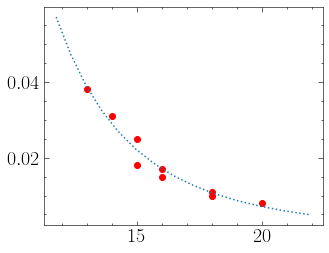

In [13]:
fig=plt.figure()
ax = fig.add_subplot(111)

###FUS
y_FUS=MFPT_FUS[0]
z_FUS=MFPT_FUS[1]
logA_FUS = np.log(z_FUS) 
logB_FUS = np.log(y_FUS)
m_FUS, c_FUS = np.polyfit(logA_FUS, logB_FUS, 1, w=np.sqrt(y_FUS)) # fit log(y) = m*log(x) + c
logA_FUS_2=np.arange(np.min(logA_FUS)-0.1, np.max(logA_FUS)+0.1, (np.max(logA_FUS)-np.min(logA_FUS))/len(logA_FUS))
z_FUS_2=np.exp(logA_FUS_2)
y_fit_FUS = np.exp(m_FUS*logA_FUS_2 + c_FUS) #calculate the fitted values of y 
plt.plot(z_FUS, y_FUS, color = 'r',lw=0,marker='o')
plt.plot(z_FUS_2, y_fit_FUS, ':')

plt.show()

In [144]:
for SIM in np.arange(0,NsimulationsFUS):
    print(SIM)

0
1
2
3
4
5
6
7
8


m_FUS is -3.932707
m_DDX4 is -2.119362 


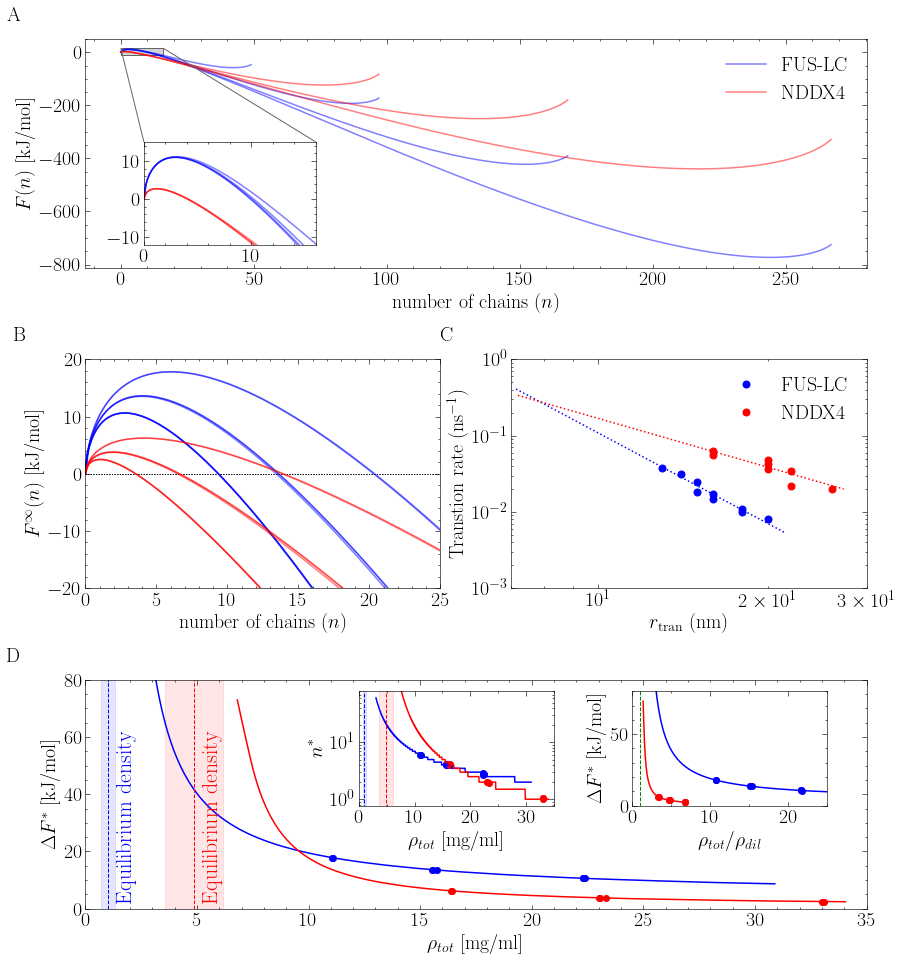

In [145]:
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator
## Define FES confined and macroscopic
FES_confined=lambda nn, N, peq, sigma, p0, p1, vl, r, kT, : -nn*kT*np.log(p1/peq)+sigma*4*np.pi*np.power(r,2)+nn*(kT-vl*peq)+N*kT*np.log(p1/p0);
FES_macro=lambda nn, peq, sigma, p0, r, kT, : -nn*kT*np.log(p0/peq)+sigma*4*np.pi*np.power(r,2);

## Plot sub-figures setup
fig = plt.figure(figsize=(14, 16))
sub0 = fig.add_subplot(3,2,(1,2))
sub1 = fig.add_subplot(3,2,3)
sub2 = fig.add_subplot(3,2,4)
sub3 = fig.add_subplot(3,2,(5,6))

fig.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    #wspace=0.4,
                    hspace=0.4)

## labels
sub1.set_xlabel('number of chains ($n$)')
sub1.set_ylabel('$F^{\infty}(n)$ [kJ/mol]')
sub2.set_xlabel(r'$r_\mathrm{tran}$ (nm)')
sub2.set_ylabel('Transtion rate (ns$^{-1}$)')
sub3.set_xlabel('$\\rho_d^\circ$ [mg/ml]')
sub3.set_ylabel('$\\Delta{F}^*$ [kJ/mol]')
sub0.set_xlabel('number of chains ($n$)')
sub0.set_ylabel('$F(n)$ [kJ/mol]')

## insets
ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(sub0, [0.075,0.1,0.22,0.45])
ax2.set_axes_locator(ip)
ax2.set_xlim([0,16])
ax2.set_ylim([-12,15]) 
mark_inset(sub0, ax2, loc1=1, loc2=2, fc="lightgray", ec='0.4')

## insets
ax3 = plt.axes([1,1,1,1])
ip2 = InsetPosition(sub3, [0.35,0.45,0.25,0.5])
ax3.set_axes_locator(ip2)
ax3.set_xlabel('$\\rho_d^\circ$ [mg/ml]')
ax3.set_ylabel('$n^*$')

ax4 = plt.axes([1,1,1,1])
ip2 = InsetPosition(sub3, [0.7,0.45,0.25,0.5])
ax4.set_axes_locator(ip2)
ax4.set_xlabel('$\\rho_d^\circ/\\rho_d^*$')
ax4.set_ylabel('$\\Delta{F}^*$ [kJ/mol]')

## label 
sub0.text(-0.1, 1.10, 'A', transform=sub0.transAxes,verticalalignment='center')
sub1.text(-0.2, 1.10, 'B', transform=sub1.transAxes,verticalalignment='center')
sub2.text(-0.2, 1.10, 'C', transform=sub2.transAxes,verticalalignment='center')
sub3.text(-0.1, 1.10, 'D', transform=sub3.transAxes,verticalalignment='center')

sub3.set_xlim([0,35])
ax3.set_xlim([0,35])
ax4.set_xlim([0,25])
#######################################################################
#####FUS rate
y_FUS=MFPT_FUS[0]
z_FUS=MFPT_FUS[1]
logA_FUS = np.log(z_FUS) 
logB_FUS = np.log(y_FUS)
m_FUS, c_FUS = np.polyfit(logA_FUS, logB_FUS, 1, w=np.sqrt(y_FUS)) # fit log(y) = m*log(x) + c
logA_FUS_2=np.arange(np.min(logA_FUS)-0.6, np.max(logA_FUS)+0.1, (np.max(logA_FUS)-np.min(logA_FUS))/len(logA_FUS))
z_FUS_2=np.exp(logA_FUS_2)
y_fit_FUS = np.exp(m_FUS*logA_FUS_2 + c_FUS) #calculate the fitted values of y 
sub2.plot(z_FUS, y_FUS,label = "FUS-LC",marker="o",markersize=7,color='b',linestyle=None,linewidth=0)
sub2.plot(z_FUS_2, y_fit_FUS,':',color='b')
sub2.set_yscale('log')
sub2.set_xscale('log')
sub2.set_xlim(7,30)
sub2.set_ylim(0.001,1)
sub2.set_yscale('log')
#####DDX4 rate
y_DDX4=MFPT_DDX4[0][:8]
z_DDX4=MFPT_DDX4[1][:8]
logA_DDX4 = np.log(z_DDX4) 
logB_DDX4 = np.log(y_DDX4)
m_DDX4, c_DDX4 = np.polyfit(logA_DDX4, logB_DDX4, 1, w=np.sqrt(y_DDX4)) # fit log(y) = m*log(x) + c
logA_DDX4_2=np.arange(np.min(logA_DDX4)-0.8, np.max(logA_DDX4)+0.1, (np.max(logA_DDX4)-np.min(logA_DDX4))/len(logA_DDX4))
z_DDX4_2=np.exp(logA_DDX4_2)
y_fit_DDX4 = np.exp(m_DDX4*logA_DDX4_2 + c_DDX4) #calculate the fitted values of y 
sub2.plot(z_DDX4, y_DDX4,label = "NDDX4",marker="o",markersize=7,color='r',linestyle=None,linewidth=0)
sub2.plot(z_DDX4_2, y_fit_DDX4,':',color='r')
sub2.set_yscale('log')
sub2.set_xscale('log')
#sub2.set_xlim(10,30)
#sub2.set_ylim(0.001,1)
sub2.set_xlim(7,30)
sub2.set_ylim(0.001,1)
sub2.set_yscale('log')
lgd=sub2.legend(loc='best', frameon=False, ncol=1)
#######################################################################
#compute FUS Free Energies (and plot panel 1)
for SIM in np.arange(0,NsimulationsFUS):
    #Compute FES given the fitted parameters
    nn=np.linspace(0, dataFUS.Ntot[SIM]-1, num=1000)
    p0=p0FUS[SIM]
    p1=kT*(dataFUS.Ntot[SIM]-nn)/(VFUS[SIM]-nn*vlFUS)
    r=np.power(3*nn*vlFUS/4/np.pi,1/3);
    FES=FES_confined(nn,dataFUS.Ntot[SIM],peq_FUS_estimate,sigma_FUS_estimate,p0,p1,vlFUS,r,kT)   
    FESm=FES_macro(nn, peq_FUS_estimate, sigma_FUS_estimate, p0, r, kT)
    #only plot one nominal density, different system sizes
    if SIM==0 or SIM==2 or SIM==5 or SIM==8: 
        lineFUS,=sub0.plot(nn,FES,'b',alpha=0.5,label='FUS')
        ax2.plot(nn,FES,'b',alpha=0.5)
    #plot all macroscopic FES    
    sub1.plot(nn,FESm,'b',alpha=0.5)
    sub1.axhline(0,color="black",alpha=0.3,lw=1.0,ls=":")
    sub1.set_ylim([-20,20])
    sub1.set_xlim([0,25])
    #compute steady state droplet size, critical nucleus size, and nucleation barrier
    argminF_FUS[SIM]=nn[FES==np.min(FES)]
    argmaxF_FUS[SIM]=nn[FESm==np.max(FESm)]
    DF_FUS[SIM]=np.max(FESm)
    #plot stuff in subpanels
    sub3.scatter(p0*ml_nm3*weightFUS/kT,DF_FUS[SIM],color='blue')
    ax3.scatter(p0*ml_nm3*weightFUS/kT,argmaxF_FUS[SIM],color='blue')
    ax4.scatter(p0*ml_nm3*weightFUS/kT/LD_FUS_estimate,DF_FUS[SIM],color='blue')

#NDDX4 Free Energies (and plot panel 1)    
for SIM in np.arange(0,NsimulationsDDX):
    #Compute FES given the fitted parameters
    nn=np.linspace(0, dataDDX.Ntot[SIM]-1, num=1000)
    p0=p0DDX[SIM]
    p1=kT*(dataDDX.Ntot[SIM]-nn)/(VDDX[SIM]-nn*vlDDX)
    r=np.power(3*nn*vlDDX/4/np.pi,1/3);
    FES=FES_confined(nn,dataDDX.Ntot[SIM],peq_DDX_estimate,sigma_DDX_estimate,p0,p1,vlDDX,r,kT)   
    FESm=FES_macro(nn, peq_DDX_estimate, sigma_DDX_estimate, p0, r, kT)
    #only plot one nominal density, different system sizes
    if SIM==1 or SIM==4 or SIM==7: 
        lineDDX,=sub0.plot(nn,FES,'r',alpha=0.5,label='NDDX4')
        ax2.plot(nn,FES,'r',alpha=0.5,label='NDDX4')
    #plot all macroscopic FES
    sub1.plot(nn,FESm,'r',alpha=0.5)
    sub1.set_ylim([-20,20])
    sub1.set_xlim([0,25])
    #compute steady state droplet size, critical nucleus size, and nucleation barrier
    argminF_DDX[SIM]=nn[FES==np.min(FES)]
    argmaxF_DDX[SIM]=nn[FESm==np.max(FESm)]
    DF_DDX[SIM]=np.max(FESm)
    #plot stuff in subpanels
    sub3.scatter(p0*ml_nm3*weightDDX/kT,DF_DDX[SIM],color='red')
    ax3.scatter(p0*ml_nm3*weightDDX/kT,argmaxF_DDX[SIM],color='red') 
    ax4.scatter(p0*ml_nm3*weightDDX/kT/LD_DDX_estimate,DF_DDX[SIM],color='red')
    
#Compute nucleation barrier and critical nucleus size as a function of system size from the model
#FUS
nn=np.linspace(0, 500, num=1000)
P0=np.linspace(peq_FUS_estimate*3,peq_FUS_estimate*30,1000)
DFFUS=np.zeros(np.shape(P0))
ncritFUS=np.zeros(np.shape(P0))
for i in np.arange(0,np.shape(P0)[0]):
    p0=P0[i]
    r=np.power(3*nn*vlFUS/4/np.pi,1/3);
    FESm=FES_macro(nn, peq_FUS_estimate, sigma_FUS_estimate, p0, r, kT)
    DFFUS[i]=np.max(FESm)
    ncritFUS[i]=nn[FESm==np.max(FESm)]
sub3.plot(P0*ml_nm3*weightFUS/kT,DFFUS,'b')
ax3.plot(P0*ml_nm3*weightFUS/kT,ncritFUS,'b')
ax4.plot(P0*ml_nm3*weightFUS/kT/LD_FUS_estimate,DFFUS,'b')

#DDX4 
P0=np.linspace(peq_DDX_estimate*1.4,peq_DDX_estimate*7,1000)
DFDDX=np.zeros(np.shape(P0))
ncritDDX=np.zeros(np.shape(P0))
for i in np.arange(0,np.shape(P0)[0]):
    p0=P0[i]
    r=np.power(3*nn*vlDDX/4/np.pi,1/3);
    FESm=FES_macro(nn, peq_DDX_estimate, sigma_DDX_estimate, p0, r, kT)
    DFDDX[i]=np.max(FESm[1:200])
    ncritDDX[i]=nn[FESm==np.max(FESm)]
sub3.plot(P0*ml_nm3*weightDDX/kT,DFDDX,'r')
ax3.plot(P0*ml_nm3*weightDDX/kT,ncritDDX,'r')
ax4.plot(P0*ml_nm3*weightDDX/kT/LD_DDX_estimate,DFDDX,'r')

#plot critical nucleus sizes in inset
ax3.plot([LD_FUS_estimate, LD_FUS_estimate],[0, 80],'--b',Linewidth=1.0)
ax3.plot([LD_DDX_estimate, LD_DDX_estimate],[0, 80],'--r',Linewidth=1.0)
ax3.add_patch(Rectangle((LD_DDX_estimate-LD_DDX_err, 0), 2*LD_DDX_err, 100,color='red',alpha=0.1))
ax3.add_patch(Rectangle((LD_FUS_estimate-LD_FUS_err, 0), 2*LD_FUS_err, 100,color='blue',alpha=0.1))
ax3.set_yscale("log")
ax3.set_ylim([0,80])
ax3.set_xticks([0, 10, 20, 30])
ax3.xaxis.set_minor_locator(AutoMinorLocator(2))

#plot equilibrium density estimate with confidence interval
sub3.plot([LD_FUS_estimate, LD_FUS_estimate],[0, 80],'--b',Linewidth=1.0)
sub3.plot([LD_DDX_estimate, LD_DDX_estimate],[0, 80],'--r',Linewidth=1.0)
sub3.add_patch(Rectangle((LD_DDX_estimate-LD_DDX_err, 0), 2*LD_DDX_err, 100,color='red',alpha=0.1))
sub3.add_patch(Rectangle((LD_FUS_estimate-LD_FUS_err, 0), 2*LD_FUS_err, 100,color='blue',alpha=0.1))
sub3.set_ylim([0,80])

####plot sencond inset scale
ax4.set_ylim(0,80)
ax4.set_xticks([0, 10, 20])
ax4.xaxis.set_minor_locator(AutoMinorLocator(2))
ax4.plot([1,1],[0, 100],'--',color="green",Linewidth=1.0)

#############################################
sub3.text(0.15, 0.4, "Equilibrium density", transform=sub3.transAxes, fontsize=22,verticalalignment='center', 
          bbox=None,rotation=90,color="red")
sub3.text(0.04, 0.4, "Equilibrium density", transform=sub3.transAxes, fontsize=22,verticalalignment='center', 
          bbox=None,rotation=90,color="blue")
#############################################
sub0.legend([lineFUS,lineDDX], ['FUS-LC','NDDX4'],frameon=False)

plt.savefig('FES_3', dpi=100, bbox_inches='tight');

print("m_FUS is %lf" % m_FUS)
print("m_DDX4 is %lf " % m_DDX4)

In [146]:
print(dataFUS)
dataFUS.Ntot/(dataFUS.L**3)

  Simulation   L  Ntot  Nss
0      FUS-3  40    50   42
1      FUS-5  50    69   55
2      FUS-6  50    98   86
3      FUS-7  60    84   63
4      FUS-8  60   118  101
5      FUS-9  60   169  153
6     FUS-10  70   133  103
7     FUS-11  70   187  158
8     FUS-12  70   268  243


0    0.000781
1    0.000552
2    0.000784
3    0.000389
4    0.000546
5    0.000782
6    0.000388
7    0.000545
8    0.000781
dtype: float64

In [147]:
print(dataDDX)
dataDDX.Ntot/(dataDDX.L**3)

  Simulation   L  Ntot  Nss
0    NDDX4-5  50    69   45
1    NDDX4-6  50    98   76
2    NDDX4-7  60    84   42
3    NDDX4-8  60   118   84
4    NDDX4-9  60   169  139
5   NDDX4-10  70   133   71
6   NDDX4-11  70   187  130
7   NDDX4-12  70   268  214


0    0.000552
1    0.000784
2    0.000389
3    0.000546
4    0.000782
5    0.000388
6    0.000545
7    0.000781
dtype: float64

FUS 3=
FUS 6=
2=
5=
m_FUS is -3.932707
m_DDX4 is -2.119362 


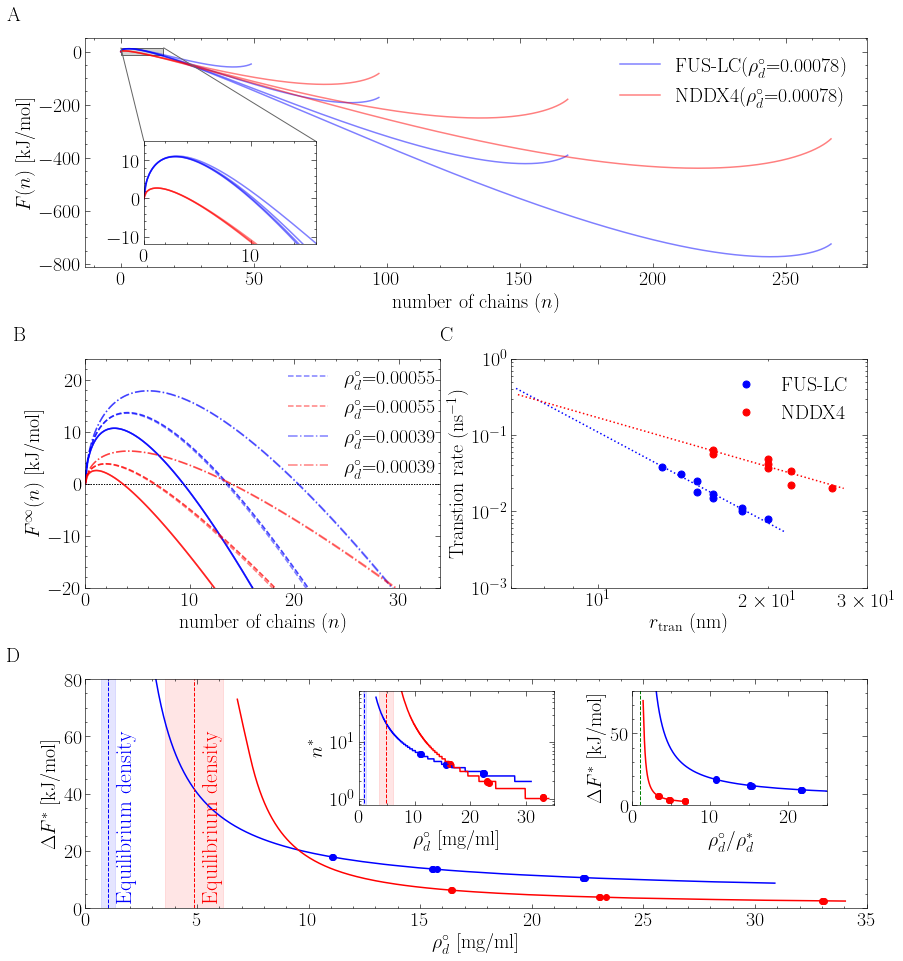

In [178]:
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator
## Define FES confined and macroscopic
FES_confined=lambda nn, N, peq, sigma, p0, p1, vl, r, kT, : -nn*kT*np.log(p1/peq)+sigma*4*np.pi*np.power(r,2)+nn*(kT-vl*peq)+N*kT*np.log(p1/p0);
FES_macro=lambda nn, peq, sigma, p0, r, kT, : -nn*kT*np.log(p0/peq)+sigma*4*np.pi*np.power(r,2);

## Plot sub-figures setup
fig = plt.figure(figsize=(14, 16))
sub0 = fig.add_subplot(3,2,(1,2))
sub1 = fig.add_subplot(3,2,3)
sub2 = fig.add_subplot(3,2,4)
sub3 = fig.add_subplot(3,2,(5,6))

fig.subplots_adjust(#left=0.1,
                    #bottom=0.1,
                    #right=0.9,
                    #top=0.9,
                    #wspace=0.4,
                    hspace=0.4)

## labels
sub1.set_xlabel('number of chains ($n$)')
sub1.set_ylabel('$F^{\infty}(n)$ [kJ/mol]')
sub2.set_xlabel(r'$r_\mathrm{tran}$ (nm)')
sub2.set_ylabel('Transtion rate (ns$^{-1}$)')
sub3.set_xlabel('$\\rho_d^\circ$ [mg/ml]')
sub3.set_ylabel('$\\Delta{F}^*$ [kJ/mol]')
sub0.set_xlabel('number of chains ($n$)')
sub0.set_ylabel('$F(n)$ [kJ/mol]')

## insets
ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(sub0, [0.075,0.1,0.22,0.45])
ax2.set_axes_locator(ip)
ax2.set_xlim([0,16])
ax2.set_ylim([-12,15]) 
mark_inset(sub0, ax2, loc1=1, loc2=2, fc="lightgray", ec='0.4')

## insets
ax3 = plt.axes([1,1,1,1])
ip2 = InsetPosition(sub3, [0.35,0.45,0.25,0.5])
ax3.set_axes_locator(ip2)
ax3.set_xlabel('$\\rho_d^\circ$ [mg/ml]')
ax3.set_ylabel('$n^*$')

ax4 = plt.axes([1,1,1,1])
ip2 = InsetPosition(sub3, [0.7,0.45,0.25,0.5])
ax4.set_axes_locator(ip2)
ax4.set_xlabel('$\\rho_d^\circ/\\rho_d^*$')
ax4.set_ylabel('$\\Delta{F}^*$ [kJ/mol]')

## label 
sub0.text(-0.1, 1.10, 'A', transform=sub0.transAxes,verticalalignment='center')
sub1.text(-0.2, 1.10, 'B', transform=sub1.transAxes,verticalalignment='center')
sub2.text(-0.2, 1.10, 'C', transform=sub2.transAxes,verticalalignment='center')
sub3.text(-0.1, 1.10, 'D', transform=sub3.transAxes,verticalalignment='center')

sub3.set_xlim([0,35])
ax3.set_xlim([0,35])
ax4.set_xlim([0,25])
#######################################################################
#####FUS rate
y_FUS=MFPT_FUS[0]
z_FUS=MFPT_FUS[1]
logA_FUS = np.log(z_FUS) 
logB_FUS = np.log(y_FUS)
m_FUS, c_FUS = np.polyfit(logA_FUS, logB_FUS, 1, w=np.sqrt(y_FUS)) # fit log(y) = m*log(x) + c
logA_FUS_2=np.arange(np.min(logA_FUS)-0.6, np.max(logA_FUS)+0.1, (np.max(logA_FUS)-np.min(logA_FUS))/len(logA_FUS))
z_FUS_2=np.exp(logA_FUS_2)
y_fit_FUS = np.exp(m_FUS*logA_FUS_2 + c_FUS) #calculate the fitted values of y 
sub2.plot(z_FUS, y_FUS,label = "FUS-LC",marker="o",markersize=7,color='b',linestyle=None,linewidth=0)
sub2.plot(z_FUS_2, y_fit_FUS,':',color='b')
sub2.set_yscale('log')
sub2.set_xscale('log')
sub2.set_xlim(7,30)
sub2.set_ylim(0.001,1)
sub2.set_yscale('log')
#####DDX4 rate
y_DDX4=MFPT_DDX4[0][:8]
z_DDX4=MFPT_DDX4[1][:8]
logA_DDX4 = np.log(z_DDX4) 
logB_DDX4 = np.log(y_DDX4)
m_DDX4, c_DDX4 = np.polyfit(logA_DDX4, logB_DDX4, 1, w=np.sqrt(y_DDX4)) # fit log(y) = m*log(x) + c
logA_DDX4_2=np.arange(np.min(logA_DDX4)-0.8, np.max(logA_DDX4)+0.1, (np.max(logA_DDX4)-np.min(logA_DDX4))/len(logA_DDX4))
z_DDX4_2=np.exp(logA_DDX4_2)
y_fit_DDX4 = np.exp(m_DDX4*logA_DDX4_2 + c_DDX4) #calculate the fitted values of y 
sub2.plot(z_DDX4, y_DDX4,label = "NDDX4",marker="o",markersize=7,color='r',linestyle=None,linewidth=0)
sub2.plot(z_DDX4_2, y_fit_DDX4,':',color='r')
sub2.set_yscale('log')
sub2.set_xscale('log')
#sub2.set_xlim(10,30)
#sub2.set_ylim(0.001,1)
sub2.set_xlim(7,30)
sub2.set_ylim(0.001,1)
sub2.set_yscale('log')
lgd=sub2.legend(loc='best', frameon=False, ncol=1)
#######################################################################
#compute FUS Free Energies (and plot panel 1)
for SIM in np.arange(0,NsimulationsFUS):
    #Compute FES given the fitted parameters
    nn=np.linspace(0, dataFUS.Ntot[SIM]-1, num=1000)
    p0=p0FUS[SIM]
    p1=kT*(dataFUS.Ntot[SIM]-nn)/(VFUS[SIM]-nn*vlFUS)
    r=np.power(3*nn*vlFUS/4/np.pi,1/3);
    FES=FES_confined(nn,dataFUS.Ntot[SIM],peq_FUS_estimate,sigma_FUS_estimate,p0,p1,vlFUS,r,kT)   
    FESm=FES_macro(nn, peq_FUS_estimate, sigma_FUS_estimate, p0, r, kT)
    #only plot one nominal density, different system sizes
    if SIM==0 or SIM==2 or SIM==5 or SIM==8: 
        lineFUS,=sub0.plot(nn,FES,'b',alpha=0.5,label='FUS')
        ax2.plot(nn,FES,'b',alpha=0.5)
    
    #plot all macroscopic FES    
    if SIM==0 or SIM==2 or SIM==5 or SIM==8:
        lineFUSm1,=sub1.plot(nn,FESm,'b',alpha=0.5,ls='-')
    else:
        if SIM==1 or SIM==4 or SIM==7:
            lineFUSm2,=sub1.plot(nn,FESm,'b',alpha=0.5,ls='--')
        else:
            print("FUS %d=" % SIM)
            lineFUSm3,=sub1.plot(nn,FESm,'b',alpha=0.5,ls='-.')
    sub1.axhline(0,color="black",alpha=0.3,lw=1.0,ls=":")
    sub1.set_ylim([-20,24])
    sub1.set_xlim([0,34])
    
    #compute steady state droplet size, critical nucleus size, and nucleation barrier
    argminF_FUS[SIM]=nn[FES==np.min(FES)]
    argmaxF_FUS[SIM]=nn[FESm==np.max(FESm)]
    DF_FUS[SIM]=np.max(FESm)
    #plot stuff in subpanels
    sub3.scatter(p0*ml_nm3*weightFUS/kT,DF_FUS[SIM],color='blue')
    ax3.scatter(p0*ml_nm3*weightFUS/kT,argmaxF_FUS[SIM],color='blue')
    ax4.scatter(p0*ml_nm3*weightFUS/kT/LD_FUS_estimate,DF_FUS[SIM],color='blue')

#NDDX4 Free Energies (and plot panel 1)    
for SIM in np.arange(0,NsimulationsDDX):
    #Compute FES given the fitted parameters
    nn=np.linspace(0, dataDDX.Ntot[SIM]-1, num=1000)
    p0=p0DDX[SIM]
    p1=kT*(dataDDX.Ntot[SIM]-nn)/(VDDX[SIM]-nn*vlDDX)
    r=np.power(3*nn*vlDDX/4/np.pi,1/3);
    FES=FES_confined(nn,dataDDX.Ntot[SIM],peq_DDX_estimate,sigma_DDX_estimate,p0,p1,vlDDX,r,kT)   
    FESm=FES_macro(nn, peq_DDX_estimate, sigma_DDX_estimate, p0, r, kT)
    #only plot one nominal density, different system sizes
    if SIM==1 or SIM==4 or SIM==7: 
        lineDDX,=sub0.plot(nn,FES,'r',alpha=0.5,label='NDDX4')
        ax2.plot(nn,FES,'r',alpha=0.5,label='NDDX4')        
    
    #plot all macroscopic FES
    if SIM==1 or SIM==4 or SIM==7:
        lineDDXm1,=sub1.plot(nn,FESm,'r',alpha=0.5,ls="-")
    else: 
        if SIM==0 or SIM==3 or SIM==6:
            lineDDXm2,=sub1.plot(nn,FESm,'r',alpha=0.5,ls="--")
        else:
            print("%d=" % SIM)
            lineDDXm3,=sub1.plot(nn,FESm,'r',alpha=0.5,ls="-.")
    sub1.set_ylim([-20,24])
    sub1.set_xlim([0,34])
    
    #compute steady state droplet size, critical nucleus size, and nucleation barrier
    argminF_DDX[SIM]=nn[FES==np.min(FES)]
    argmaxF_DDX[SIM]=nn[FESm==np.max(FESm)]
    DF_DDX[SIM]=np.max(FESm)
    #plot stuff in subpanels
    sub3.scatter(p0*ml_nm3*weightDDX/kT,DF_DDX[SIM],color='red')
    ax3.scatter(p0*ml_nm3*weightDDX/kT,argmaxF_DDX[SIM],color='red') 
    ax4.scatter(p0*ml_nm3*weightDDX/kT/LD_DDX_estimate,DF_DDX[SIM],color='red')
    
#Compute nucleation barrier and critical nucleus size as a fulineDDXm,nction of system size from the model
#FUS
nn=np.linspace(0, 500, num=1000)
P0=np.linspace(peq_FUS_estimate*3,peq_FUS_estimate*30,1000)
DFFUS=np.zeros(np.shape(P0))
ncritFUS=np.zeros(np.shape(P0))
for i in np.arange(0,np.shape(P0)[0]):
    p0=P0[i]
    r=np.power(3*nn*vlFUS/4/np.pi,1/3);
    FESm=FES_macro(nn, peq_FUS_estimate, sigma_FUS_estimate, p0, r, kT)
    DFFUS[i]=np.max(FESm)
    ncritFUS[i]=nn[FESm==np.max(FESm)]
sub3.plot(P0*ml_nm3*weightFUS/kT,DFFUS,'b')
ax3.plot(P0*ml_nm3*weightFUS/kT,ncritFUS,'b')
ax4.plot(P0*ml_nm3*weightFUS/kT/LD_FUS_estimate,DFFUS,'b')

#DDX4 
P0=np.linspace(peq_DDX_estimate*1.4,peq_DDX_estimate*7,1000)
DFDDX=np.zeros(np.shape(P0))
ncritDDX=np.zeros(np.shape(P0))
for i in np.arange(0,np.shape(P0)[0]):
    p0=P0[i]
    r=np.power(3*nn*vlDDX/4/np.pi,1/3);
    FESm=FES_macro(nn, peq_DDX_estimate, sigma_DDX_estimate, p0, r, kT)
    DFDDX[i]=np.max(FESm[1:200])
    ncritDDX[i]=nn[FESm==np.max(FESm)]
sub3.plot(P0*ml_nm3*weightDDX/kT,DFDDX,'r')
ax3.plot(P0*ml_nm3*weightDDX/kT,ncritDDX,'r')
ax4.plot(P0*ml_nm3*weightDDX/kT/LD_DDX_estimate,DFDDX,'r')

#plot critical nucleus sizes in inset
ax3.plot([LD_FUS_estimate, LD_FUS_estimate],[0, 80],'--b',Linewidth=1.0)
ax3.plot([LD_DDX_estimate, LD_DDX_estimate],[0, 80],'--r',Linewidth=1.0)
ax3.add_patch(Rectangle((LD_DDX_estimate-LD_DDX_err, 0), 2*LD_DDX_err, 100,color='red',alpha=0.1))
ax3.add_patch(Rectangle((LD_FUS_estimate-LD_FUS_err, 0), 2*LD_FUS_err, 100,color='blue',alpha=0.1))
ax3.set_yscale("log")
ax3.set_ylim([0,80])
ax3.set_xticks([0, 10, 20, 30])
ax3.xaxis.set_minor_locator(AutoMinorLocator(2))

#plot equilibrium density estimate with confidence interval
sub3.plot([LD_FUS_estimate, LD_FUS_estimate],[0, 80],'--b',Linewidth=1.0)
sub3.plot([LD_DDX_estimate, LD_DDX_estimate],[0, 80],'--r',Linewidth=1.0)
sub3.add_patch(Rectangle((LD_DDX_estimate-LD_DDX_err, 0), 2*LD_DDX_err, 100,color='red',alpha=0.1))
sub3.add_patch(Rectangle((LD_FUS_estimate-LD_FUS_err, 0), 2*LD_FUS_err, 100,color='blue',alpha=0.1))
sub3.set_ylim([0,80])

####plot sencond inset scale
ax4.set_ylim(0,80)
ax4.set_xticks([0, 10, 20])
ax4.xaxis.set_minor_locator(AutoMinorLocator(2))
ax4.plot([1,1],[0, 100],'--',color="green",Linewidth=1.0)

#############################################
sub3.text(0.15, 0.4, "Equilibrium density", transform=sub3.transAxes, fontsize=22,verticalalignment='center', 
          bbox=None,rotation=90,color="red")
sub3.text(0.04, 0.4, "Equilibrium density", transform=sub3.transAxes, fontsize=22,verticalalignment='center', 
          bbox=None,rotation=90,color="blue")
#############################################
sub0.legend([lineFUS,lineDDX], [r'FUS-LC($\rho_d^\circ$=0.00078)',r'NDDX4($\rho_d^\circ$=0.00078)'],frameon=False)
sub1.legend([lineFUSm2,lineDDXm2,lineFUSm3,lineDDXm3], [r'$\rho_d^\circ$=0.00055',r'$\rho_d^\circ$=0.00055',
             r'$\rho_d^\circ$=0.00039',r'$\rho_d^\circ$=0.00039'],bbox_to_anchor=(0.52, 0.4),
            frameon=False)
#leg = sub1.legend()
#for line in leg.get_lines():
#    line.set_linewidth(4.0)

plt.savefig('FES_4', dpi=100, bbox_inches='tight');

print("m_FUS is %lf" % m_FUS)
print("m_DDX4 is %lf " % m_DDX4)

m_FUS is -3.932707
m_DDX4 is -2.119362 


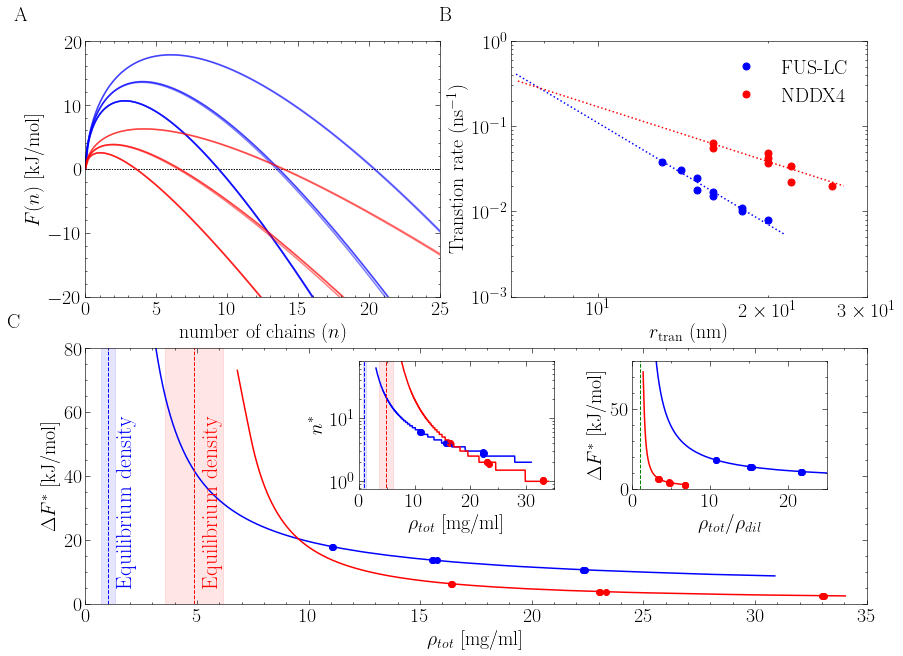

In [149]:
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator
## Define FES confined and macroscopic
FES_confined=lambda nn, N, peq, sigma, p0, p1, vl, r, kT, : -nn*kT*np.log(p1/peq)+sigma*4*np.pi*np.power(r,2)+nn*(kT-vl*peq)+N*kT*np.log(p1/p0);
FES_macro=lambda nn, peq, sigma, p0, r, kT, : -nn*kT*np.log(p0/peq)+sigma*4*np.pi*np.power(r,2);

## Plot sub-figures setup
fig = plt.figure(figsize=(14, 16))
sub1 = fig.add_subplot(3,2,1)
sub2 = fig.add_subplot(3,2,2)
sub3 = fig.add_subplot(3,2,(3,4))

## labels
sub1.set_xlabel('number of chains ($n$)')
sub1.set_ylabel('$F(n)$ [kJ/mol]')
sub2.set_xlabel(r'$r_\mathrm{tran}$ (nm)')
sub2.set_ylabel('Transtion rate (ns$^{-1}$)')
sub3.set_xlabel('$\\rho_d^\circ$ [mg/ml]')
sub3.set_ylabel('$\\Delta{F}^*$ [kJ/mol]')

## insets
ax3 = plt.axes([1,1,1,1])
ip2 = InsetPosition(sub3, [0.35,0.45,0.25,0.5])
ax3.set_axes_locator(ip2)
ax3.set_xlabel('$\\rho_d^\circ$ [mg/ml]')
ax3.set_ylabel('$n^*$')

ax4 = plt.axes([1,1,1,1])
ip2 = InsetPosition(sub3, [0.7,0.45,0.25,0.5])
ax4.set_axes_locator(ip2)
ax4.set_xlabel('$\\rho_d^\circ/\\rho_d^*$')
ax4.set_ylabel('$\\Delta{F}^*$ [kJ/mol]')

## label 
sub1.text(-0.2, 1.10, 'A', transform=sub1.transAxes,verticalalignment='center')
sub2.text(-0.2, 1.10, 'B', transform=sub2.transAxes,verticalalignment='center')
sub3.text(-0.1, 1.10, 'C', transform=sub3.transAxes,verticalalignment='center')

sub3.set_xlim([0,35])
ax3.set_xlim([0,35])
ax4.set_xlim([0,25])
#######################################################################
#####FUS rate
y_FUS=MFPT_FUS[0]
z_FUS=MFPT_FUS[1]
logA_FUS = np.log(z_FUS) 
logB_FUS = np.log(y_FUS)
m_FUS, c_FUS = np.polyfit(logA_FUS, logB_FUS, 1, w=np.sqrt(y_FUS)) # fit log(y) = m*log(x) + c
logA_FUS_2=np.arange(np.min(logA_FUS)-0.6, np.max(logA_FUS)+0.1, (np.max(logA_FUS)-np.min(logA_FUS))/len(logA_FUS))
z_FUS_2=np.exp(logA_FUS_2)
y_fit_FUS = np.exp(m_FUS*logA_FUS_2 + c_FUS) #calculate the fitted values of y 
sub2.plot(z_FUS, y_FUS,label = "FUS-LC",marker="o",markersize=7,color='b',linestyle=None,linewidth=0)
sub2.plot(z_FUS_2, y_fit_FUS,':',color='b')
sub2.set_yscale('log')
sub2.set_xscale('log')
sub2.set_xlim(7,30)
sub2.set_ylim(0.001,1)
sub2.set_yscale('log')
#####DDX4 rate
y_DDX4=MFPT_DDX4[0][:8]
z_DDX4=MFPT_DDX4[1][:8]
logA_DDX4 = np.log(z_DDX4) 
logB_DDX4 = np.log(y_DDX4)
m_DDX4, c_DDX4 = np.polyfit(logA_DDX4, logB_DDX4, 1, w=np.sqrt(y_DDX4)) # fit log(y) = m*log(x) + c
logA_DDX4_2=np.arange(np.min(logA_DDX4)-0.8, np.max(logA_DDX4)+0.1, (np.max(logA_DDX4)-np.min(logA_DDX4))/len(logA_DDX4))
z_DDX4_2=np.exp(logA_DDX4_2)
y_fit_DDX4 = np.exp(m_DDX4*logA_DDX4_2 + c_DDX4) #calculate the fitted values of y 
sub2.plot(z_DDX4, y_DDX4,label = "NDDX4",marker="o",markersize=7,color='r',linestyle=None,linewidth=0)
sub2.plot(z_DDX4_2, y_fit_DDX4,':',color='r')
sub2.set_yscale('log')
sub2.set_xscale('log')
#sub2.set_xlim(10,30)
#sub2.set_ylim(0.001,1)
sub2.set_xlim(7,30)
sub2.set_ylim(0.001,1)
sub2.set_yscale('log')
lgd=sub2.legend(loc='best', frameon=False, ncol=1)
#######################################################################
#compute FUS Free Energies (and plot panel 1)
for SIM in np.arange(0,NsimulationsFUS):
    #Compute FES given the fitted parameters
    nn=np.linspace(0, dataFUS.Ntot[SIM]-1, num=1000)
    p0=p0FUS[SIM]
    p1=kT*(dataFUS.Ntot[SIM]-nn)/(VFUS[SIM]-nn*vlFUS)
    r=np.power(3*nn*vlFUS/4/np.pi,1/3);
    FES=FES_confined(nn,dataFUS.Ntot[SIM],peq_FUS_estimate,sigma_FUS_estimate,p0,p1,vlFUS,r,kT)   
    FESm=FES_macro(nn, peq_FUS_estimate, sigma_FUS_estimate, p0, r, kT)
    #only plot one nominal density, different system sizes
    #if SIM==0 or SIM==2 or SIM==5 or SIM==8: 
    #    lineFUS,=sub1.plot(nn,FES,'b',alpha=0.5,label='FUS')
    #    ax2.plot(nn,FES,'b',alpha=0.5)
    #plot all macroscopic FES    
    sub1.plot(nn,FESm,'b',alpha=0.5)
    sub1.axhline(0,color="black",alpha=0.3,lw=1.0,ls=":")
    sub1.set_ylim([-20,20])
    sub1.set_xlim([0,25])
    #compute steady state droplet size, critical nucleus size, and nucleation barrier
    argminF_FUS[SIM]=nn[FES==np.min(FES)]
    argmaxF_FUS[SIM]=nn[FESm==np.max(FESm)]
    DF_FUS[SIM]=np.max(FESm)
    #plot stuff in subpanels
    sub3.scatter(p0*ml_nm3*weightFUS/kT,DF_FUS[SIM],color='blue')
    ax3.scatter(p0*ml_nm3*weightFUS/kT,argmaxF_FUS[SIM],color='blue')
    ax4.scatter(p0*ml_nm3*weightFUS/kT/LD_FUS_estimate,DF_FUS[SIM],color='blue')

#NDDX4 Free Energies (and plot panel 1)    
for SIM in np.arange(0,NsimulationsDDX):
    #Compute FES given the fitted parameters
    nn=np.linspace(0, dataDDX.Ntot[SIM]-1, num=1000)
    p0=p0DDX[SIM]
    p1=kT*(dataDDX.Ntot[SIM]-nn)/(VDDX[SIM]-nn*vlDDX)
    r=np.power(3*nn*vlDDX/4/np.pi,1/3);
    FES=FES_confined(nn,dataDDX.Ntot[SIM],peq_DDX_estimate,sigma_DDX_estimate,p0,p1,vlDDX,r,kT)   
    FESm=FES_macro(nn, peq_DDX_estimate, sigma_DDX_estimate, p0, r, kT)
    #only plot one nominal density, different system sizes
    #if SIM==1 or SIM==4 or SIM==7: 
    #    lineDDX,=sub1.plot(nn,FES,'r',alpha=0.5,label='NDDX4')
    #    ax2.plot(nn,FES,'r',alpha=0.5,label='NDDX4')
    #plot all macroscopic FES
    sub1.plot(nn,FESm,'r',alpha=0.5)
    sub1.set_ylim([-20,20])
    sub1.set_xlim([0,25])
    #compute steady state droplet size, critical nucleus size, and nucleation barrier
    argminF_DDX[SIM]=nn[FES==np.min(FES)]
    argmaxF_DDX[SIM]=nn[FESm==np.max(FESm)]
    DF_DDX[SIM]=np.max(FESm)
    #plot stuff in subpanels
    sub3.scatter(p0*ml_nm3*weightDDX/kT,DF_DDX[SIM],color='red')
    ax3.scatter(p0*ml_nm3*weightDDX/kT,argmaxF_DDX[SIM],color='red') 
    ax4.scatter(p0*ml_nm3*weightDDX/kT/LD_DDX_estimate,DF_DDX[SIM],color='red')
    
#Compute nucleation barrier and critical nucleus size as a function of system size from the model
#FUS
nn=np.linspace(0, 500, num=1000)
P0=np.linspace(peq_FUS_estimate*3,peq_FUS_estimate*30,1000)
DFFUS=np.zeros(np.shape(P0))
ncritFUS=np.zeros(np.shape(P0))
for i in np.arange(0,np.shape(P0)[0]):
    p0=P0[i]
    r=np.power(3*nn*vlFUS/4/np.pi,1/3);
    FESm=FES_macro(nn, peq_FUS_estimate, sigma_FUS_estimate, p0, r, kT)
    DFFUS[i]=np.max(FESm)
    ncritFUS[i]=nn[FESm==np.max(FESm)]
sub3.plot(P0*ml_nm3*weightFUS/kT,DFFUS,'b')
ax3.plot(P0*ml_nm3*weightFUS/kT,ncritFUS,'b')
ax4.plot(P0*ml_nm3*weightFUS/kT/LD_FUS_estimate,DFFUS,'b')

#DDX4 
P0=np.linspace(peq_DDX_estimate*1.4,peq_DDX_estimate*7,1000)
DFDDX=np.zeros(np.shape(P0))
ncritDDX=np.zeros(np.shape(P0))
for i in np.arange(0,np.shape(P0)[0]):
    p0=P0[i]
    r=np.power(3*nn*vlDDX/4/np.pi,1/3);
    FESm=FES_macro(nn, peq_DDX_estimate, sigma_DDX_estimate, p0, r, kT)
    DFDDX[i]=np.max(FESm[1:200])
    ncritDDX[i]=nn[FESm==np.max(FESm)]
sub3.plot(P0*ml_nm3*weightDDX/kT,DFDDX,'r')
ax3.plot(P0*ml_nm3*weightDDX/kT,ncritDDX,'r')
ax4.plot(P0*ml_nm3*weightDDX/kT/LD_DDX_estimate,DFDDX,'r')

#plot critical nucleus sizes in inset
ax3.plot([LD_FUS_estimate, LD_FUS_estimate],[0, 80],'--b',Linewidth=1.0)
ax3.plot([LD_DDX_estimate, LD_DDX_estimate],[0, 80],'--r',Linewidth=1.0)
ax3.add_patch(Rectangle((LD_DDX_estimate-LD_DDX_err, 0), 2*LD_DDX_err, 100,color='red',alpha=0.1))
ax3.add_patch(Rectangle((LD_FUS_estimate-LD_FUS_err, 0), 2*LD_FUS_err, 100,color='blue',alpha=0.1))
ax3.set_yscale("log")
ax3.set_ylim([0,80])
ax3.set_xticks([0, 10, 20, 30])
ax3.xaxis.set_minor_locator(AutoMinorLocator(2))

#plot equilibrium density estimate with confidence interval
sub3.plot([LD_FUS_estimate, LD_FUS_estimate],[0, 80],'--b',Linewidth=1.0)
sub3.plot([LD_DDX_estimate, LD_DDX_estimate],[0, 80],'--r',Linewidth=1.0)
sub3.add_patch(Rectangle((LD_DDX_estimate-LD_DDX_err, 0), 2*LD_DDX_err, 100,color='red',alpha=0.1))
sub3.add_patch(Rectangle((LD_FUS_estimate-LD_FUS_err, 0), 2*LD_FUS_err, 100,color='blue',alpha=0.1))
sub3.set_ylim([0,80])

####plot sencond inset scale
ax4.set_ylim(0,80)
ax4.set_xticks([0, 10, 20])
ax4.xaxis.set_minor_locator(AutoMinorLocator(2))
ax4.plot([1,1],[0, 100],'--',color="green",Linewidth=1.0)

#############################################
sub3.text(0.15, 0.4, "Equilibrium density", transform=sub3.transAxes, fontsize=22,verticalalignment='center', 
          bbox=None,rotation=90,color="red")
sub3.text(0.04, 0.4, "Equilibrium density", transform=sub3.transAxes, fontsize=22,verticalalignment='center', 
          bbox=None,rotation=90,color="blue")
#############################################
# Save it! 
plt.savefig('FES_2', dpi=600, bbox_inches='tight');

print("m_FUS is %lf" % m_FUS)
print("m_DDX4 is %lf " % m_DDX4)

In [150]:
"At finite-size steady-state, the larger the droplet, the slower that a chainleaves the droplet to become vapour chains"

'At finite-size steady-state, the larger the droplet, the slower that a chainleaves the droplet to become vapour chains'

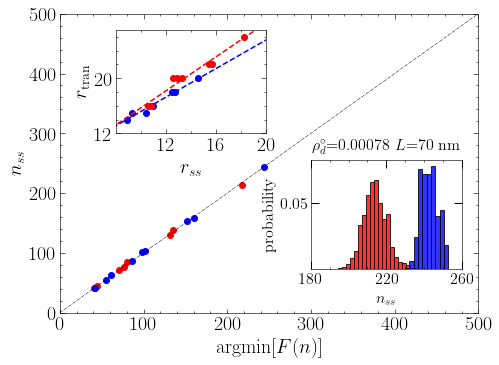

In [234]:
clustersize_DDX4_L70_rho3=np.loadtxt("2D_DDX4_L70nm_rho3_sample.txt")
clustersize_FUS_L70_rho3=np.loadtxt("2D_FUS_L70nm_rho3_sample.txt")

#Map figure
fig = plt.figure(figsize=(8, 6)) 
gw = int(np.floor(0.5 + 1000 * fig.get_figwidth()))
gh = int(np.floor(0.5 + 1000 * fig.get_figheight()))
gs = plt.GridSpec(gh, gw)
gs.update(hspace=0.0, wspace=0.0)

sub2 = fig.add_subplot(gs[500:6500,500:8000])
sub1 = fig.add_subplot(gs[3200:5200,5000:7700])
sub3 = fig.add_subplot(gs[800:2700,1500:4200])

## label 
#sub1.text(-0.1, 1.1, 'A', transform=sub1.transAxes,verticalalignment='center')
#sub2.text(-0.1, 1.1, 'B', transform=sub2.transAxes,verticalalignment='center')

####################
sub1.hist(clustersize_DDX4_L70_rho3,histtype='bar',ec='black',bins=20,color = 'red',alpha=0.8,density=True)
sub1.hist(clustersize_FUS_L70_rho3,histtype='bar',ec='black',bins=10,color = 'blue',alpha=0.8,density=True)
sub1.set_title(r"$\rho_d^\circ$=0.00078 $L$=70 nm",x=0.5, y=1.05,fontsize=16)
sub1.set_xlabel(r"$n_{ss}$",fontsize=16)
sub1.set_ylabel("probability",fontsize=16)
sub1.set_xlim([180,260])
sub1.set_xticks([180, 220, 260])
sub1.set_yticks([0.05])
sub1.tick_params(direction='in',which='major',length=8, width=1.0, labelsize=16)
####################################
sub2.set_xlabel('argmin$[F(n)]$')
sub2.set_ylabel('$n_{ss}$')
#Add parity line in panel 3
sub2.plot(nn,nn,'k-.',LineWidth=0.5)   
for SIM in np.arange(0,NsimulationsDDX):
    sub2.scatter(argminF_DDX[SIM],dataDDX.Nss[SIM],color='red')
for SIM in np.arange(0,NsimulationsFUS):
    sub2.scatter(argminF_FUS[SIM],dataFUS.Nss[SIM],color='blue') 
sub2.set_xlim(0,500)
sub2.set_ylim(0,500)
###################################
radius_DDX4_L70_rho3=np.loadtxt("DDX4_radius.txt")
radius_FUS_L70_rho3=np.loadtxt("FUS_radius.txt")

x_DDX4=radius_DDX4_L70_rho3[:,0]
A_DDX4 = np.vstack([x_DDX4, np.ones(len(x_DDX4))]).T
A_DDX4
y_DDX4=radius_DDX4_L70_rho3[:,1]
m_DDX4, c_DDX4 = np.linalg.lstsq(A_DDX4, y_DDX4, rcond=None)[0]
x_DDX4_2=np.arange(5, 21, 5, dtype=int)

x_FUS=radius_FUS_L70_rho3[:,0]
A_FUS = np.vstack([x_FUS, np.ones(len(x_FUS))]).T
A_FUS
y_FUS=radius_FUS_L70_rho3[:,1]
m_FUS, c_FUS = np.linalg.lstsq(A_FUS, y_FUS, rcond=None)[0]
x_FUS_2=np.arange(5, 21, 5, dtype=int)

sub3.plot(x_FUS, y_FUS, 'o', color='b')
sub3.plot(x_FUS_2, m_FUS*x_FUS_2 + c_FUS, 'b', ls="--")
sub3.plot(x_DDX4, y_DDX4, 'o', color='r')
sub3.plot(x_DDX4_2, m_DDX4*x_DDX4_2 + c_DDX4, 'r',ls="--")
sub3.set_xlabel(r'$r_{ss}$')
sub3.set_ylabel(r'$r_\mathrm{tran}$')
sub3.set_xlim(8,20)
sub3.set_ylim(12,27)
sub3.set_xticks([12, 16, 20])
sub3.set_yticks([12, 20])
sub3.xaxis.set_minor_locator(AutoMinorLocator(2))
sub3.yaxis.set_minor_locator(AutoMinorLocator(4))

# Save it! 
plt.savefig('parity', dpi=600, bbox_inches='tight');

In [183]:
ratio_FUS = np.loadtxt("rate_ratio_FUS-LC").T
ratio_FUS.shape

ratio_DDX4 = np.loadtxt("rate_ratio_NDDX4").T
ratio_DDX4.shape

(2, 8)

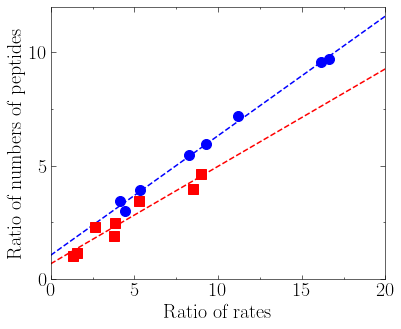

In [211]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(ratio_FUS[0],ratio_FUS[1],label = "FUS-LC",marker="o",markersize=10,color='blue',linestyle=None,linewidth=0)

x_FUS=ratio_FUS[0]
A_FUS = np.vstack([x_FUS, np.ones(len(x_FUS))]).T
A_FUS
y_FUS=ratio_FUS[1]
m_FUS, c_FUS = np.linalg.lstsq(A_FUS, y_FUS, rcond=None)[0]
x_FUS_2=np.arange(0, 21, 5, dtype=int)
ax.plot(x_FUS_2, m_FUS*x_FUS_2 + c_FUS, 'b', ls="--")

ax.plot(ratio_DDX4[0],ratio_DDX4[1],label = "NDDX4",marker="s",markersize=10,color='red',linestyle=None,linewidth=0)
x_DDX4=ratio_DDX4[0]
A_DDX4 = np.vstack([x_DDX4, np.ones(len(x_DDX4))]).T
A_DDX4
y_DDX4=ratio_DDX4[1]
m_DDX4, c_DDX4 = np.linalg.lstsq(A_DDX4, y_DDX4, rcond=None)[0]
x_DDX4_2=np.arange(0, 21, 5, dtype=int)
ax.plot(x_DDX4_2, m_DDX4*x_DDX4_2 + c_DDX4, 'r', ls="--")

ax.set_xlim(0,20)
ax.set_ylim(0,12)
ax.set_xticks(np.arange(0,21,5))
ax.set_yticks(np.arange(0,13,5))
ax.set_xlabel("Ratio of rates")
ax.set_ylabel("Ratio of numbers of peptides")
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.yaxis.set_minor_locator(AutoMinorLocator(2))
plt.savefig('ratio', dpi=600, bbox_inches='tight');

In [152]:
from scipy.signal import find_peaks

P0=np.linspace(0.4*peq_FUS_estimate,peq_DDX_estimate*7.5,200)
Vtot=np.power(np.linspace(20,350,200),3)
[PP0,VVtot]=np.meshgrid(P0,Vtot)
NNtot=VVtot*PP0/kT
CLASS_DDX=np.zeros(np.shape(NNtot))

for i in np.arange(0,np.shape(P0)[0]):
    for j in np.arange(0,np.shape(Vtot)[0]):
        p0=PP0[i][j]
        nn=np.linspace(0, NNtot[i][j]-1, num=10000)
        p1=kT*(NNtot[i][j]-nn)/(VVtot[i][j]-nn*vlDDX)
        r=np.power(3*nn*vlDDX/4/np.pi,1/3);
        FES=FES_confined(nn,NNtot[i][j],peq_DDX_estimate,sigma_DDX_estimate,p0,p1,vlDDX,r,kT)
        aux=-np.abs(np.gradient(FES))
        peaks, _ = find_peaks(FES)
        CLASS_DDX[i][j]=np.size(peaks)            
            
CLASS_FUS=np.zeros(np.shape(NNtot))
for i in np.arange(0,np.shape(P0)[0]):
    for j in np.arange(0,np.shape(Vtot)[0]):
        p0=PP0[i][j]
        nn=np.linspace(0, NNtot[i][j]-1, num=10000)
        p1=kT*(NNtot[i][j]-nn)/(VVtot[i][j]-nn*vlFUS)
        r=np.power(3*nn*vlFUS/4/np.pi,1/3);
        FES=FES_confined(nn,NNtot[i][j],peq_FUS_estimate,sigma_FUS_estimate,p0,p1,vlFUS,r,kT)
        aux=-np.abs(np.gradient(FES))
        peaks, _ = find_peaks(FES)
        CLASS_FUS[i][j]=np.size(peaks)

Text(0, 0.5, '$F(n)$')

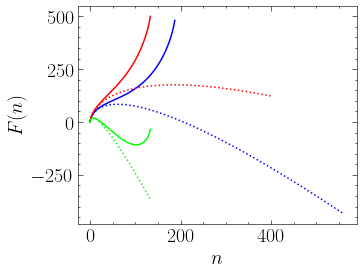

In [153]:
FES_confined_test=lambda nn, N, peq, sigma, p0, vl, r, kT, V: -nn*kT*np.log(kT*(N-nn)/(V-nn*vl)/peq)+sigma*4*np.pi*np.power(r,2)+nn*(kT-vl*peq)+N*kT*np.log(kT*(N-nn)/(V-nn*vl)/p0);
FES_macro_test=lambda nn, peq, sigma, p0, r, kT, : -nn*kT*np.log(p0/peq)+sigma*4*np.pi*np.power(r,2);

N_test=187
FUS_nk=np.linspace(0, N_test*3, num=10000)
V_test=120**3
FUS_p0=kT*N_test/V_test
FUS_r_test=np.power(3*FUS_nk*vlFUS/4/np.pi,1/3);
FUS_FES_test=FES_confined_test(FUS_nk,N_test,peq_FUS_estimate,sigma_FUS_estimate,FUS_p0,vlFUS,FUS_r_test,kT,V_test)
FUS_FESm_test=FES_macro_test(FUS_nk, peq_FUS_estimate, sigma_FUS_estimate, FUS_p0, FUS_r_test, kT)

N_test_2=133
FUS_nk_2=np.linspace(0, N_test_2*3, num=10000)
V_test_2=120**3
FUS_p0_2=kT*N_test_2/V_test_2
FUS_r_test_2=np.power(3*FUS_nk_2*vlFUS/4/np.pi,1/3);
FUS_FES_test_2=FES_confined_test(FUS_nk_2,N_test_2,peq_FUS_estimate,sigma_FUS_estimate,FUS_p0_2,vlFUS,FUS_r_test_2,kT,V_test_2)
FUS_FESm_test_2=FES_macro_test(FUS_nk_2, peq_FUS_estimate, sigma_FUS_estimate, FUS_p0_2, FUS_r_test_2, kT)

N_test_3=133 #170 #see if faster than 187
FUS_nk_3=np.linspace(0, N_test_3, num=10000)
V_test_3=70**3
FUS_p0_3=kT*N_test_3/V_test_3
FUS_r_test_3=np.power(3*FUS_nk_3*vlFUS/4/np.pi,1/3);
FUS_FES_test_3=FES_confined_test(FUS_nk_3,N_test_3,peq_FUS_estimate,sigma_FUS_estimate,FUS_p0_3,vlFUS,FUS_r_test_3,kT,V_test_3)
FUS_FESm_test_3=FES_macro_test(FUS_nk_3, peq_FUS_estimate, sigma_FUS_estimate, FUS_p0_3, FUS_r_test_3, kT)

plt.plot(FUS_nk,FUS_FES_test-FUS_FES_test[0],color="b")
plt.plot(FUS_nk,FUS_FESm_test-FUS_FESm_test[0],color="b",ls=":")
plt.plot(FUS_nk_2,FUS_FES_test_2-FUS_FES_test_2[0],color="r")
plt.plot(FUS_nk_2,FUS_FESm_test_2-FUS_FESm_test_2[0],color="r",ls=":")
plt.plot(FUS_nk_3,FUS_FES_test_3-FUS_FES_test_3[0],color="lime")
plt.plot(FUS_nk_3,FUS_FESm_test_3-FUS_FESm_test_3[0],color="lime",ls=":")
plt.xlabel(r"$n$")
plt.ylabel(r"$F(n)$")
#plt.xlim(0,25)
#plt.ylim(-20,50)

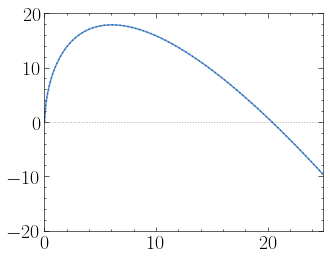

In [154]:
N_test_3=133 #170 #see if faster than 187
FUS_nk_3=np.linspace(0, N_test_3, num=10000)
V_test_3=70**3
FUS_p0_3=kT*N_test_3/V_test_3
FUS_r_test_3=np.power(3*FUS_nk_3*vlFUS/4/np.pi,1/3);
FUS_FES_test_3=FES_confined_test(FUS_nk_3,N_test_3,peq_FUS_estimate,sigma_FUS_estimate,FUS_p0_3,vlFUS,FUS_r_test_3,kT,V_test_3)
FUS_FESm_test_3=FES_macro_test(FUS_nk_3, peq_FUS_estimate, sigma_FUS_estimate, FUS_p0_3, FUS_r_test_3, kT)
plt.plot(FUS_nk_3,FUS_FESm_test_3-FUS_FESm_test_3[0],color="lime",ls=":")

for SIM in np.arange(0,NsimulationsFUS):
    if SIM==6:
        #Compute FES given the fitted parameters
        nn=np.linspace(0, dataFUS.Ntot[SIM]-1, num=1000)
        p0=p0FUS[SIM]
        p1=kT*(dataFUS.Ntot[SIM]-nn)/(VFUS[SIM]-nn*vlFUS)
        r=np.power(3*nn*vlFUS/4/np.pi,1/3);
        FES=FES_confined(nn,dataFUS.Ntot[SIM],peq_FUS_estimate,sigma_FUS_estimate,p0,p1,vlFUS,r,kT)   
        FESm=FES_macro(nn, peq_FUS_estimate, sigma_FUS_estimate, p0, r, kT)
        #only plot one nominal density, different system sizes
        #if SIM==0 or SIM==2 or SIM==5 or SIM==8: 
        #    lineFUS,=sub1.plot(nn,FES,'b',alpha=0.5,label='FUS')
        #    ax2.plot(nn,FES,'b',alpha=0.5)
        #plot all macroscopic FES    
        plt.plot(nn,FESm,'b',alpha=0.5)
        plt.axhline(0,color="black",alpha=0.3,lw=1.0,ls=":")
        plt.ylim([-20,20])
        plt.xlim([0,25])
        #compute steady state droplet size, critical nucleus size, and nucleation barrier
        argminF_FUS[SIM]=nn[FES==np.min(FES)]
        argmaxF_FUS[SIM]=nn[FESm==np.max(FESm)]
        DF_FUS[SIM]=np.max(FESm)

Text(0, 0.5, '$F(n)$')

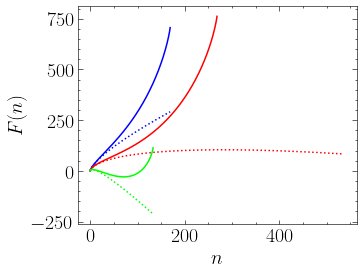

In [155]:
#FES_confined_test=lambda nn, N, peq, sigma, p0, vl, r, kT, V: -nn*kT*np.log(kT*(N-nn)/(V-nn*vl)/peq)+sigma*4*np.pi*np.power(r,2)+nn*(kT-vl*peq)+N*kT*np.log(kT*(N-nn)/(V-nn*vl)/p0);
#FES_macro_test=lambda nn, peq, sigma, p0, r, kT, : -nn*kT*np.log(p0/peq)+sigma*4*np.pi*np.power(r,2);

N_test=169
DDX_nk=np.linspace(0, N_test, num=10000)
V_test=120**3
DDX_p0=kT*N_test/V_test
DDX_r_test=np.power(3*DDX_nk*vlDDX/4/np.pi,1/3);
DDX_FES_test=FES_confined_test(DDX_nk,N_test,peq_DDX_estimate,sigma_DDX_estimate,DDX_p0,vlDDX,DDX_r_test,kT,V_test)
DDX_FESm_test=FES_macro_test(DDX_nk, peq_DDX_estimate, sigma_DDX_estimate, DDX_p0, DDX_r_test, kT)

N_test_2=268
DDX_nk_2=np.linspace(0, N_test_2*2, num=10000)
V_test_2=120**3
DDX_p0_2=kT*N_test_2/V_test_2
DDX_r_test_2=np.power(3*DDX_nk_2*vlDDX/4/np.pi,1/3);
DDX_FES_test_2=FES_confined_test(DDX_nk_2,N_test_2,peq_DDX_estimate,sigma_DDX_estimate,DDX_p0_2,vlDDX,DDX_r_test_2,kT,V_test_2)
DDX_FESm_test_2=FES_macro_test(DDX_nk_2, peq_DDX_estimate, sigma_DDX_estimate, DDX_p0_2, DDX_r_test_2, kT)

N_test_3=133 #170 #see if faster than 187
DDX_nk_3=np.linspace(0, N_test_3, num=10000)
V_test_3=70**3
DDX_p0_3=kT*N_test_3/V_test_3
DDX_r_test_3=np.power(3*DDX_nk_3*vlDDX/4/np.pi,1/3);
DDX_FES_test_3=FES_confined_test(DDX_nk_3,N_test_3,peq_DDX_estimate,sigma_DDX_estimate,DDX_p0_3,vlDDX,DDX_r_test_3,kT,V_test_3)
DDX_FESm_test_3=FES_macro_test(DDX_nk_3, peq_DDX_estimate, sigma_DDX_estimate, DDX_p0_3, DDX_r_test_3, kT)

plt.plot(DDX_nk,DDX_FES_test-DDX_FES_test[0],color="b")
plt.plot(DDX_nk,DDX_FESm_test-DDX_FESm_test[0],color="b",ls=":")
plt.plot(DDX_nk_2,DDX_FES_test_2-DDX_FES_test_2[0],color="r")
plt.plot(DDX_nk_2,DDX_FESm_test_2-DDX_FESm_test_2[0],color="r",ls=":")
plt.plot(DDX_nk_3,DDX_FES_test_3-DDX_FES_test_3[0],color="lime")
plt.plot(DDX_nk_3,DDX_FESm_test_3-DDX_FESm_test_3[0],color="lime",ls=":")
plt.xlabel(r"$n$")
plt.ylabel(r"$F(n)$")

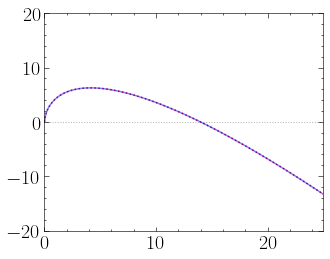

In [156]:
N_test_3=133 #170 #see if faster than 187
DDX_nk_3=np.linspace(0, N_test_3, num=10000)
V_test_3=70**3
DDX_p0_3=kT*N_test_3/V_test_3
DDX_r_test_3=np.power(3*DDX_nk_3*vlDDX/4/np.pi,1/3);
DDX_FES_test_3=FES_confined_test(DDX_nk_3,N_test_3,peq_DDX_estimate,sigma_DDX_estimate,DDX_p0_3,vlDDX,DDX_r_test_3,kT,V_test_3)
DDX_FESm_test_3=FES_macro_test(DDX_nk_3, peq_DDX_estimate, sigma_DDX_estimate, DDX_p0_3, DDX_r_test_3, kT)
plt.plot(DDX_nk_3,DDX_FESm_test_3-DDX_FESm_test_3[0],color="red",ls=":")

for SIM in np.arange(0,NsimulationsDDX):
    if SIM==5:
        #Compute FES given the fitted parameters
        nn=np.linspace(0, dataDDX.Ntot[SIM]-1, num=1000)
        p0=p0DDX[SIM]
        p1=kT*(dataDDX.Ntot[SIM]-nn)/(VDDX[SIM]-nn*vlDDX)
        r=np.power(3*nn*vlDDX/4/np.pi,1/3);
        FES=FES_confined(nn,dataDDX.Ntot[SIM],peq_DDX_estimate,sigma_DDX_estimate,p0,p1,vlDDX,r,kT)   
        FESm=FES_macro(nn, peq_DDX_estimate, sigma_DDX_estimate, p0, r, kT)
        #only plot one nominal density, different system sizes
        #if SIM==0 or SIM==2 or SIM==5 or SIM==8: 
        #    lineDDX,=sub1.plot(nn,FES,'b',alpha=0.5,label='DDX')
        #    ax2.plot(nn,FES,'b',alpha=0.5)
        #plot all macroscopic FES    
        plt.plot(nn,FESm,'b',alpha=0.5)
        plt.axhline(0,color="black",alpha=0.3,lw=1.0,ls=":")
        plt.ylim([-20,20])
        plt.xlim([0,25])
        #compute steady state droplet size, critical nucleus size, and nucleation barrier
        argminF_DDX[SIM]=nn[FES==np.min(FES)]
        argmaxF_DDX[SIM]=nn[FESm==np.max(FESm)]
        DF_DDX[SIM]=np.max(FESm)

In [157]:
m = ['x', '^', '^', '^', '^','^','^','^','^','^','^','^','x','x','x','x']
len(m)

16

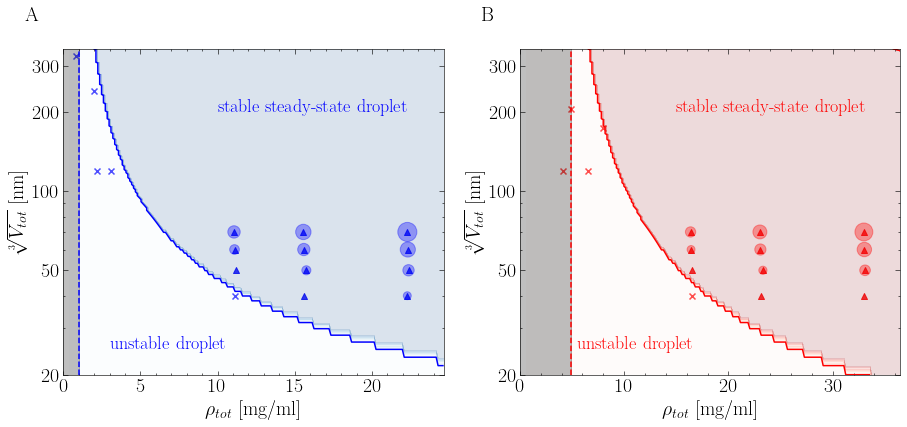

In [158]:
#Map figure
fig = plt.figure(figsize=(15,6)) 
subDDX = fig.add_subplot(1,2,2)
subFUS = fig.add_subplot(1,2,1)

## label 
subFUS.text(-0.1, 1.1, 'A', transform=subFUS.transAxes,verticalalignment='center')
subDDX.text(-0.1, 1.1, 'B', transform=subDDX.transAxes,verticalalignment='center')

#Load data for FUS and compute FUS variables 
AllSimsFUS = pd.read_excel(r'AllSimsFUS.xlsx')
VFUSAll=np.power(AllSimsFUS.L,3)
p0FUSAll=kT*(AllSimsFUS.N)/VFUSAll

#Load data for DDX4 and compute DDX4 variables 
AllSimsDDX = pd.read_excel(r'AllSimsDDX.xlsx')
VDDXAll=np.power(AllSimsDDX.L,3)
p0DDXAll=kT*(AllSimsDDX.N)/VDDXAll

#Plot Map DDX4 
for i in range(len(AllSimsDDX.N)):
    subDDX.scatter(p0DDXAll[i]*ml_nm3*weightDDX/kT,np.power(VDDXAll[i],1/3),color='r',marker=m[i],alpha=0.8)
subDDX.contourf(PP0*ml_nm3*weightDDX/kT,np.power(VVtot,1/3),CLASS_DDX,cmap='Reds',alpha=0.15)
subDDX.contour(PP0*ml_nm3*weightDDX/kT,np.power(VVtot,1/3),CLASS_DDX,[1],colors=['r'])
subDDX.plot([LD_DDX_estimate, LD_DDX_estimate],[np.min(np.power(Vtot,1/3)), np.max(np.power(Vtot,1/3))],'--',color='red',Linewidth=1.5)
subDDX.scatter(p0DDX*ml_nm3*weightDDX/kT,np.power(VDDX,1/3),color='red',s=1.5*dataDDX.Nss,alpha=0.35)
subDDX.set_xlabel('$\\rho_d^\circ$ [mg/ml]')
subDDX.set_ylabel('$\sqrt[3]{V_{tot}}$ [nm]')

#Plot Map FUS 
for i in range(len(AllSimsDDX.N)):
    subFUS.scatter(p0FUSAll[i]*ml_nm3*weightFUS/kT,np.power(VFUSAll[i],1/3),color='b',marker=m[i],alpha=0.8)
subFUS.contourf(PP0*ml_nm3*weightFUS/kT,np.power(VVtot,1/3),CLASS_FUS,cmap='Blues',alpha=0.15)
subFUS.contour(PP0*ml_nm3*weightFUS/kT,np.power(VVtot,1/3),CLASS_FUS,[1],colors=['b'])
subFUS.plot([LD_FUS_estimate, LD_FUS_estimate],[np.min(np.power(Vtot,1/3)), np.max(np.power(Vtot,1/3))],'--',color='blue',Linewidth=1.5)
subFUS.scatter(p0FUS*ml_nm3*weightFUS/kT,np.power(VFUS,1/3),color='blue',s=1.5*dataFUS.Nss,alpha=0.35)
subFUS.set_xlabel('$\\rho_d^\circ$ [mg/ml]')
subFUS.set_ylabel('$\sqrt[3]{V_{tot}}$ [nm]')

# Annotate plumed
subFUS.annotate('stable steady-state droplet',xy=(10,200),color='blue',fontsize=18)
subDDX.annotate('stable steady-state droplet',xy=(15,200),color='red',fontsize=18)
subFUS.annotate('unstable droplet',xy=(3,25),color='blue',fontsize=18)
subDDX.annotate('unstable droplet',xy=(5.5,25),color='red',fontsize=18)

subDDX.set_yscale('log')
subFUS.set_yscale('log')
subDDX.set_yticks([20, 50, 100, 200, 300])
subDDX.set_yticklabels([20, 50, 100, 200, 300])
subFUS.set_yticks([20, 50, 100, 200, 300])
subFUS.set_yticklabels([20, 50, 100, 200, 300])

subFUS.set_xlim(0,)
subDDX.set_xlim(0,)


subFUS.add_patch(Rectangle((0,0),LD_FUS_estimate,400,color='black',alpha=0.25))
subDDX.add_patch(Rectangle((0,0),LD_DDX_estimate,400,color='black',alpha=0.25))

plt.savefig('maps_FUS_DDX_2', dpi=600, bbox_inches='tight');

(0.0, 1000.0)

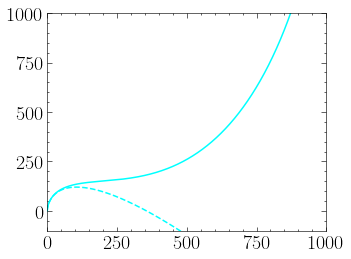

In [159]:
N_test_4=1000
FUS_nk_4=np.linspace(0, N_test_4, num=10000)
V_test_4=223**3
FUS_p0_4=kT*N_test_4/V_test_4
FUS_r_test_4=np.power(3*FUS_nk_4*vlFUS/4/np.pi,1/3);
FUS_FES_test_4=FES_confined_test(FUS_nk_4,N_test_4,peq_FUS_estimate,sigma_FUS_estimate,FUS_p0_4,vlFUS,FUS_r_test_4,kT,V_test_4)
FUS_FESm_test_4=FES_macro_test(FUS_nk_4, peq_FUS_estimate, sigma_FUS_estimate, FUS_p0_4, FUS_r_test_4, kT)
plt.plot(FUS_nk_4,FUS_FES_test_4-FUS_FES_test_4[0],color="cyan",ls="-")
plt.plot(FUS_nk_4,FUS_FESm_test_4-FUS_FESm_test_4[0],color="cyan",ls="--")
plt.ylim(-100,1000)
plt.xlim(0,1000)

(0.0, 400.0)

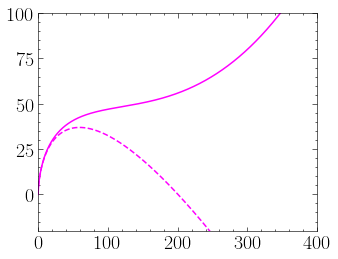

In [160]:
N_test_4=1000
DDX_nk_4=np.linspace(0, N_test_4, num=10000)
V_test_4=174**3
DDX_p0_4=kT*N_test_4/V_test_4
DDX_r_test_4=np.power(3*DDX_nk_4*vlDDX/4/np.pi,1/3);
DDX_FES_test_4=FES_confined_test(DDX_nk_4,N_test_4,peq_DDX_estimate,sigma_DDX_estimate,DDX_p0_4,vlDDX,DDX_r_test_4,kT,V_test_4)
DDX_FESm_test_4=FES_macro_test(DDX_nk_4, peq_DDX_estimate, sigma_DDX_estimate, DDX_p0_4, DDX_r_test_4, kT)
plt.plot(DDX_nk_4,DDX_FES_test_4-DDX_FES_test_4[0],color="magenta",ls="-")
plt.plot(DDX_nk_4,DDX_FESm_test_4-DDX_FESm_test_4[0],color="magenta",ls="--")
plt.ylim(-20,100)
plt.xlim(0,400)

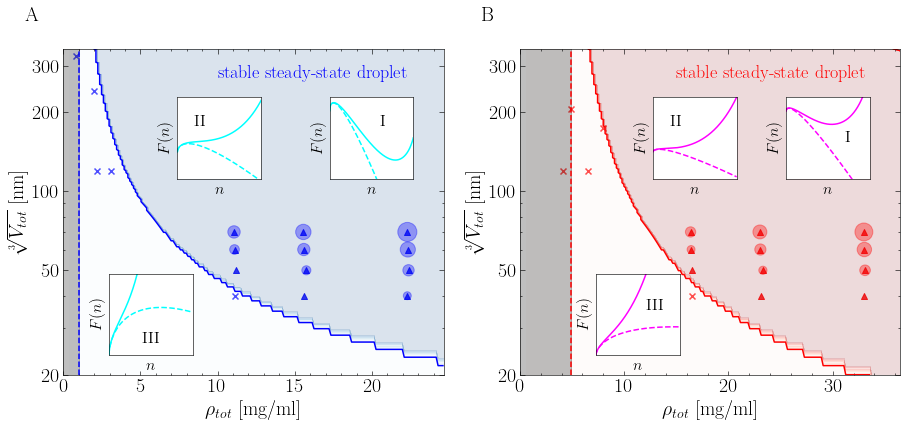

In [161]:
#Map figure
fig = plt.figure(figsize=(15,6)) 
subDDX = fig.add_subplot(1,2,2)
subFUS = fig.add_subplot(1,2,1)

## label 
subFUS.text(-0.1, 1.1, 'A', transform=subFUS.transAxes,verticalalignment='center')
subDDX.text(-0.1, 1.1, 'B', transform=subDDX.transAxes,verticalalignment='center')

#Load data for FUS and compute FUS variables 
AllSimsFUS = pd.read_excel(r'AllSimsFUS.xlsx')
VFUSAll=np.power(AllSimsFUS.L,3)
p0FUSAll=kT*(AllSimsFUS.N)/VFUSAll

#Load data for DDX4 and compute DDX4 variables 
AllSimsDDX = pd.read_excel(r'AllSimsDDX.xlsx')
VDDXAll=np.power(AllSimsDDX.L,3)
p0DDXAll=kT*(AllSimsDDX.N)/VDDXAll

#Plot Map DDX4 
for i in range(len(AllSimsDDX.N)):
    subDDX.scatter(p0DDXAll[i]*ml_nm3*weightDDX/kT,np.power(VDDXAll[i],1/3),color='r',marker=m[i],alpha=0.8)
subDDX.contourf(PP0*ml_nm3*weightDDX/kT,np.power(VVtot,1/3),CLASS_DDX,cmap='Reds',alpha=0.15)
subDDX.contour(PP0*ml_nm3*weightDDX/kT,np.power(VVtot,1/3),CLASS_DDX,[1],colors=['r'])
subDDX.plot([LD_DDX_estimate, LD_DDX_estimate],[np.min(np.power(Vtot,1/3)), np.max(np.power(Vtot,1/3))],'--',color='red',Linewidth=1.5)
subDDX.scatter(p0DDX*ml_nm3*weightDDX/kT,np.power(VDDX,1/3),color='red',s=1.5*dataDDX.Nss,alpha=0.35)
subDDX.set_xlabel('$\\rho_d^\circ$ [mg/ml]')
subDDX.set_ylabel('$\sqrt[3]{V_{tot}}$ [nm]')

#Plot Map FUS 
for i in range(len(AllSimsDDX.N)):
    subFUS.scatter(p0FUSAll[i]*ml_nm3*weightFUS/kT,np.power(VFUSAll[i],1/3),color='b',marker=m[i],alpha=0.8)
subFUS.contourf(PP0*ml_nm3*weightFUS/kT,np.power(VVtot,1/3),CLASS_FUS,cmap='Blues',alpha=0.15)
subFUS.contour(PP0*ml_nm3*weightFUS/kT,np.power(VVtot,1/3),CLASS_FUS,[1],colors=['b'])
subFUS.plot([LD_FUS_estimate, LD_FUS_estimate],[np.min(np.power(Vtot,1/3)), np.max(np.power(Vtot,1/3))],'--',color='blue',Linewidth=1.5)
subFUS.scatter(p0FUS*ml_nm3*weightFUS/kT,np.power(VFUS,1/3),color='blue',s=1.5*dataFUS.Nss,alpha=0.35)
subFUS.set_xlabel('$\\rho_d^\circ$ [mg/ml]')
subFUS.set_ylabel('$\sqrt[3]{V_{tot}}$ [nm]')

# Annotate plumed
subFUS.annotate('stable steady-state droplet',xy=(10,270),color='blue',fontsize=18)
subDDX.annotate('stable steady-state droplet',xy=(15,270),color='red',fontsize=18)
#subFUS.annotate('unstable droplet',xy=(3,25),color='blue',fontsize=18)
#subDDX.annotate('unstable droplet',xy=(5.5,25),color='red',fontsize=18)

subDDX.set_yscale('log')
subFUS.set_yscale('log')
subDDX.set_yticks([20, 50, 100, 200, 300])
subDDX.set_yticklabels([20, 50, 100, 200, 300])
subFUS.set_yticks([20, 50, 100, 200, 300])
subFUS.set_yticklabels([20, 50, 100, 200, 300])

subFUS.set_xlim(0,)
subDDX.set_xlim(0,)

subFUS.add_patch(Rectangle((0,0),LD_FUS_estimate,400,color='black',alpha=0.25))
subDDX.add_patch(Rectangle((0,0),LD_DDX_estimate,400,color='black',alpha=0.25))

## insets FUS
## insets FUS
ax1 = plt.axes([1,1,1,1])
ip1 = InsetPosition(subFUS, [0.7,0.6,0.22,0.25])
ax1.set_axes_locator(ip1)
ax1.set_xlabel(r'$n$',fontsize=16)
ax1.set_ylabel(r'$F(n)$',fontsize=16)
ax1.tick_params(direction='in', which='major',length=6, width=1.0, labelsize=16)
ax1.plot(FUS_nk_3,FUS_FES_test_3-FUS_FES_test_3[0],color="cyan")
ax1.plot(FUS_nk_3,FUS_FESm_test_3-FUS_FESm_test_3[0],color="cyan",ls="--")
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = plt.axes([1,1,1,1])
ip2 = InsetPosition(subFUS, [0.12,0.06,0.22,0.25])
ax2.set_axes_locator(ip2)
ax2.set_xlabel(r'$n$',fontsize=16)
ax2.set_ylabel(r'$F(n)$',fontsize=16)
ax2.tick_params(direction='in', which='major',length=6, width=1.0, labelsize=16)
ax2.plot(FUS_nk_2,FUS_FES_test_2-FUS_FES_test_2[0],color="cyan")
ax2.plot(FUS_nk_2,FUS_FESm_test_2-FUS_FESm_test_2[0],color="cyan",ls="--")
ax2.set_xticks([])
ax2.set_yticks([])

ax5 = plt.axes([1,1,1,1])
ip5 = InsetPosition(subFUS, [0.3,0.6,0.22,0.25])
ax5.set_axes_locator(ip5)
ax5.set_xlabel(r'$n$',fontsize=16)
ax5.set_ylabel(r'$F(n)$',fontsize=16)
ax5.tick_params(direction='in', which='major',length=6, width=1.0, labelsize=16)
ax5.plot(FUS_nk_4,FUS_FES_test_4-FUS_FES_test_4[0],color="cyan")
ax5.plot(FUS_nk_4,FUS_FESm_test_4-FUS_FESm_test_4[0],color="cyan",ls="--")
ax5.set_xticks([])
ax5.set_yticks([])

## insets DDX4
## insets DDX4
ax3 = plt.axes([1,1,1,1])
ip3 = InsetPosition(subDDX, [0.7,0.6,0.22,0.25])
ax3.set_axes_locator(ip3)
ax3.set_xlabel(r'$n$',fontsize=16)
ax3.set_ylabel(r'$F(n)$',fontsize=16)
ax3.tick_params(direction='in', which='major',length=6, width=1.0, labelsize=16)
ax3.plot(DDX_nk_3,DDX_FES_test_3-DDX_FES_test_3[0],color="magenta")
ax3.plot(DDX_nk_3,DDX_FESm_test_3-DDX_FESm_test_3[0],color="magenta",ls="--")
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])

ax4 = plt.axes([1,1,1,1])
ip4 = InsetPosition(subDDX, [0.2,0.06,0.22,0.25])
ax4.set_axes_locator(ip4)
ax4.set_xlabel(r'$n$',fontsize=16)
ax4.set_ylabel(r'$F(n)$',fontsize=16)
ax4.tick_params(direction='in', which='major',length=6, width=1.0, labelsize=16)
ax4.plot(DDX_nk_2,DDX_FES_test_2-DDX_FES_test_2[0],color="magenta")
ax4.plot(DDX_nk_2,DDX_FESm_test_2-DDX_FESm_test_2[0],color="magenta",ls="--")
ax4.set_xticks([])
ax4.set_yticks([])


ax6 = plt.axes([1,1,1,1])
ip6 = InsetPosition(subDDX, [0.35,0.6,0.22,0.25])
ax6.set_axes_locator(ip6)
ax6.set_xlabel(r'$n$',fontsize=16)
ax6.set_ylabel(r'$F(n)$',fontsize=16)
ax6.tick_params(direction='in', which='major',length=6, width=1.0, labelsize=16)
ax6.plot(DDX_nk_4,DDX_FES_test_4-DDX_FES_test_4[0],color="magenta")
ax6.plot(DDX_nk_4,DDX_FESm_test_4-DDX_FESm_test_4[0],color="magenta",ls="--")
ax6.set_xticks([])
ax6.set_yticks([])
ax6.set_xticks([])
ax6.set_yticks([])

###########same scale for insets
ax1.set_xlim(0,130)
ax1.set_ylim(-150,30)
ax2.set_xlim(0,300)
ax2.set_ylim(0,300)
ax5.set_ylim(-400,800)
ax5.set_xlim(0,800)

ax3.set_xlim(0,130)
ax3.set_ylim(-150,30)
ax4.set_xlim(0,300)
ax4.set_ylim(0,300)
ax6.set_ylim(-400,800)
ax6.set_xlim(0,800)
###############################
###label for FUS
ax2.text(0.4, 0.2, "III", transform=ax2.transAxes, fontsize=16,verticalalignment='center', 
          bbox=None,rotation=0,color="black")
ax1.text(0.6, 0.7, "I", transform=ax1.transAxes, fontsize=16,verticalalignment='center', 
          bbox=None,rotation=0,color="black")
ax5.text(0.2, 0.7, "II", transform=ax5.transAxes, fontsize=16,verticalalignment='center', 
          bbox=None,rotation=0,color="black")

####label for DDX4
ax4.text(0.6, 0.6, "III", transform=ax4.transAxes, fontsize=16,verticalalignment='center', 
          bbox=None,rotation=0,color="black")
ax3.text(0.7, 0.5, "I", transform=ax3.transAxes, fontsize=16,verticalalignment='center', 
          bbox=None,rotation=0,color="black")
ax6.text(0.2, 0.7, "II", transform=ax6.transAxes, fontsize=16,verticalalignment='center', 
          bbox=None,rotation=0,color="black")
#############################

plt.savefig('maps_FUS_DDX_3', dpi=600, bbox_inches='tight');

(0.0, 1000.0)

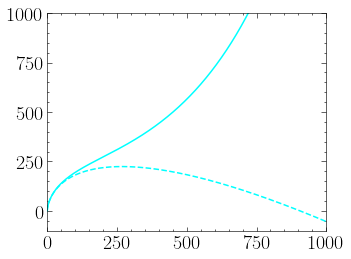

In [162]:
N_test_4_2=1000
FUS_nk_4_2=np.linspace(0, N_test_4_2, num=10000)
V_test_4_2=242**3
FUS_p0_4_2=kT*N_test_4_2/V_test_4_2
FUS_r_test_4_2=np.power(3*FUS_nk_4_2*vlFUS/4/np.pi,1/3);
FUS_FES_test_4_2=FES_confined_test(FUS_nk_4_2,N_test_4_2,peq_FUS_estimate,sigma_FUS_estimate,FUS_p0_4_2,vlFUS,FUS_r_test_4_2,kT,V_test_4_2)
FUS_FESm_test_4_2=FES_macro_test(FUS_nk_4_2, peq_FUS_estimate, sigma_FUS_estimate, FUS_p0_4_2, FUS_r_test_4_2, kT)
plt.plot(FUS_nk_4_2,FUS_FES_test_4_2-FUS_FES_test_4_2[0],color="cyan",ls="-")
plt.plot(FUS_nk_4_2,FUS_FESm_test_4_2-FUS_FESm_test_4_2[0],color="cyan",ls="--")
plt.ylim(-100,1000)
plt.xlim(0,1000)

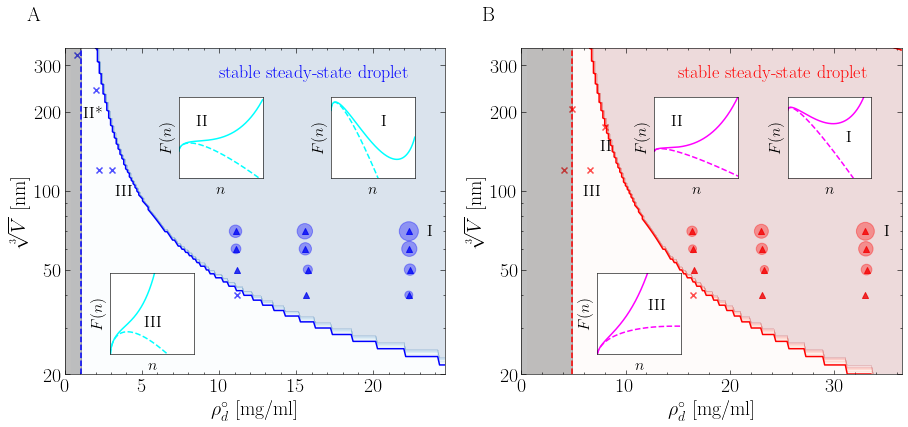

In [173]:
#Map figure
fig = plt.figure(figsize=(15,6)) 
subDDX = fig.add_subplot(1,2,2)
subFUS = fig.add_subplot(1,2,1)

## label 
subFUS.text(-0.1, 1.1, 'A', transform=subFUS.transAxes,verticalalignment='center')
subDDX.text(-0.1, 1.1, 'B', transform=subDDX.transAxes,verticalalignment='center')

#Load data for FUS and compute FUS variables 
AllSimsFUS = pd.read_excel(r'AllSimsFUS.xlsx')
VFUSAll=np.power(AllSimsFUS.L,3)
p0FUSAll=kT*(AllSimsFUS.N)/VFUSAll

#Load data for DDX4 and compute DDX4 variables 
AllSimsDDX = pd.read_excel(r'AllSimsDDX.xlsx')
VDDXAll=np.power(AllSimsDDX.L,3)
p0DDXAll=kT*(AllSimsDDX.N)/VDDXAll

#Plot Map DDX4 
for i in range(len(AllSimsDDX.N)):
    subDDX.scatter(p0DDXAll[i]*ml_nm3*weightDDX/kT,np.power(VDDXAll[i],1/3),color='r',marker=m[i],alpha=0.8)
subDDX.contourf(PP0*ml_nm3*weightDDX/kT,np.power(VVtot,1/3),CLASS_DDX,cmap='Reds',alpha=0.15)
subDDX.contour(PP0*ml_nm3*weightDDX/kT,np.power(VVtot,1/3),CLASS_DDX,[1],colors=['r'])
subDDX.plot([LD_DDX_estimate, LD_DDX_estimate],[np.min(np.power(Vtot,1/3)), np.max(np.power(Vtot,1/3))],'--',color='red',Linewidth=1.5)
subDDX.scatter(p0DDX*ml_nm3*weightDDX/kT,np.power(VDDX,1/3),color='red',s=1.5*dataDDX.Nss,alpha=0.35)
subDDX.set_xlabel('$\\rho_d^\circ$ [mg/ml]')
subDDX.set_ylabel('$\sqrt[3]{V}$ [nm]')

#Plot Map FUS 
for i in range(len(AllSimsDDX.N)):
    subFUS.scatter(p0FUSAll[i]*ml_nm3*weightFUS/kT,np.power(VFUSAll[i],1/3),color='b',marker=m[i],alpha=0.8)
subFUS.contourf(PP0*ml_nm3*weightFUS/kT,np.power(VVtot,1/3),CLASS_FUS,cmap='Blues',alpha=0.15)
subFUS.contour(PP0*ml_nm3*weightFUS/kT,np.power(VVtot,1/3),CLASS_FUS,[1],colors=['b'])
subFUS.plot([LD_FUS_estimate, LD_FUS_estimate],[np.min(np.power(Vtot,1/3)), np.max(np.power(Vtot,1/3))],'--',color='blue',Linewidth=1.5)
subFUS.scatter(p0FUS*ml_nm3*weightFUS/kT,np.power(VFUS,1/3),color='blue',s=1.5*dataFUS.Nss,alpha=0.35)
subFUS.set_xlabel('$\\rho_d^\circ$ [mg/ml]')
subFUS.set_ylabel('$\sqrt[3]{V}$ [nm]')

# Annotate plumed
subFUS.annotate('stable steady-state droplet',xy=(10,270),color='blue',fontsize=18)
subDDX.annotate('stable steady-state droplet',xy=(15,270),color='red',fontsize=18)
#subFUS.annotate('unstable droplet',xy=(3,25),color='blue',fontsize=18)
#subDDX.annotate('unstable droplet',xy=(5.5,25),color='red',fontsize=18)

subDDX.set_yscale('log')
subFUS.set_yscale('log')
subDDX.set_yticks([20, 50, 100, 200, 300])
subDDX.set_yticklabels([20, 50, 100, 200, 300])
subFUS.set_yticks([20, 50, 100, 200, 300])
subFUS.set_yticklabels([20, 50, 100, 200, 300])

subFUS.set_xlim(0,)
subDDX.set_xlim(0,)

subFUS.add_patch(Rectangle((0,0),LD_FUS_estimate,400,color='black',alpha=0.25))
subDDX.add_patch(Rectangle((0,0),LD_DDX_estimate,400,color='black',alpha=0.25))

## insets FUS
## insets FUS
ax1 = plt.axes([1,1,1,1])
ip1 = InsetPosition(subFUS, [0.7,0.6,0.22,0.25])
ax1.set_axes_locator(ip1)
ax1.set_xlabel(r'$n$',fontsize=16)
ax1.set_ylabel(r'$F(n)$',fontsize=16)
ax1.tick_params(direction='in', which='major',length=6, width=1.0, labelsize=16)
ax1.plot(FUS_nk_3,FUS_FES_test_3-FUS_FES_test_3[0],color="cyan")
ax1.plot(FUS_nk_3,FUS_FESm_test_3-FUS_FESm_test_3[0],color="cyan",ls="--")
ax1.set_xticks([])
ax1.set_yticks([])

ax2 = plt.axes([1,1,1,1])
ip2 = InsetPosition(subFUS, [0.12,0.06,0.22,0.25])
ax2.set_axes_locator(ip2)
ax2.set_xlabel(r'$n$',fontsize=16)
ax2.set_ylabel(r'$F(n)$',fontsize=16)
ax2.tick_params(direction='in', which='major',length=6, width=1.0, labelsize=16)
ax2.plot(FUS_nk,FUS_FES_test-FUS_FES_test[0],color="cyan")
ax2.plot(FUS_nk,FUS_FESm_test-FUS_FESm_test[0],color="cyan",ls="--")
#ax2.plot(FUS_nk_2,FUS_FES_test_2-FUS_FES_test_2[0],color="orange")
#ax2.plot(FUS_nk_2,FUS_FESm_test_2-FUS_FESm_test_2[0],color="orange",ls="--")
ax2.set_xticks([])
ax2.set_yticks([])

ax5 = plt.axes([1,1,1,1])
ip5 = InsetPosition(subFUS, [0.3,0.6,0.22,0.25])
ax5.set_axes_locator(ip5)
ax5.set_xlabel(r'$n$',fontsize=16)
ax5.set_ylabel(r'$F(n)$',fontsize=16)
ax5.tick_params(direction='in', which='major',length=6, width=1.0, labelsize=16)
ax5.plot(FUS_nk_4,FUS_FES_test_4-FUS_FES_test_4[0],color="cyan")
ax5.plot(FUS_nk_4,FUS_FESm_test_4-FUS_FESm_test_4[0],color="cyan",ls="--")
ax5.set_xticks([])
ax5.set_yticks([])

## insets DDX4
## insets DDX4
ax3 = plt.axes([1,1,1,1])
ip3 = InsetPosition(subDDX, [0.7,0.6,0.22,0.25])
ax3.set_axes_locator(ip3)
ax3.set_xlabel(r'$n$',fontsize=16)
ax3.set_ylabel(r'$F(n)$',fontsize=16)
ax3.tick_params(direction='in', which='major',length=6, width=1.0, labelsize=16)
ax3.plot(DDX_nk_3,DDX_FES_test_3-DDX_FES_test_3[0],color="magenta")
ax3.plot(DDX_nk_3,DDX_FESm_test_3-DDX_FESm_test_3[0],color="magenta",ls="--")
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])

ax4 = plt.axes([1,1,1,1])
ip4 = InsetPosition(subDDX, [0.2,0.06,0.22,0.25])
ax4.set_axes_locator(ip4)
ax4.set_xlabel(r'$n$',fontsize=16)
ax4.set_ylabel(r'$F(n)$',fontsize=16)
ax4.tick_params(direction='in', which='major',length=6, width=1.0, labelsize=16)
ax4.plot(DDX_nk_2,DDX_FES_test_2-DDX_FES_test_2[0],color="magenta")
ax4.plot(DDX_nk_2,DDX_FESm_test_2-DDX_FESm_test_2[0],color="magenta",ls="--")
ax4.set_xticks([])
ax4.set_yticks([])

ax6 = plt.axes([1,1,1,1])
ip6 = InsetPosition(subDDX, [0.35,0.6,0.22,0.25])
ax6.set_axes_locator(ip6)
ax6.set_xlabel(r'$n$',fontsize=16)
ax6.set_ylabel(r'$F(n)$',fontsize=16)
ax6.tick_params(direction='in', which='major',length=6, width=1.0, labelsize=16)
ax6.plot(DDX_nk_4,DDX_FES_test_4-DDX_FES_test_4[0],color="magenta")
ax6.plot(DDX_nk_4,DDX_FESm_test_4-DDX_FESm_test_4[0],color="magenta",ls="--")
ax6.set_xticks([])
ax6.set_yticks([])
ax6.set_xticks([])
ax6.set_yticks([])

###########same scale for insets
ax1.set_xlim(0,130)
ax1.set_ylim(-150,30)
ax2.set_xlim(0,300)
ax2.set_ylim(0,300)
ax5.set_ylim(-400,800)
ax5.set_xlim(0,800)

ax3.set_xlim(0,130)
ax3.set_ylim(-150,30)
ax4.set_xlim(0,300)
ax4.set_ylim(0,300)
ax6.set_ylim(-400,800)
ax6.set_xlim(0,800)
###############################
###label for FUS###########
ax2.text(0.4, 0.4, "III", transform=ax2.transAxes, fontsize=16,verticalalignment='center', 
          bbox=None,rotation=0,color="black")
ax2.text(0.05, 2.0, "III", transform=ax2.transAxes, fontsize=16,verticalalignment='center', 
          bbox=None,rotation=0,color="black")
#############################
ax1.text(0.6, 0.7, "I", transform=ax1.transAxes, fontsize=16,verticalalignment='center', 
          bbox=None,rotation=0,color="black")
ax1.text(1.15, -0.65, "I", transform=ax1.transAxes, fontsize=16,verticalalignment='center', 
          bbox=None,rotation=0,color="black")
#############################
ax5.text(0.2, 0.7, "II", transform=ax5.transAxes, fontsize=16,verticalalignment='center', 
          bbox=None,rotation=0,color="black")
ax5.text(-1.15, 0.8, "II*", transform=ax5.transAxes, fontsize=16,verticalalignment='center', 
          bbox=None,rotation=0,color="black")
##########################################################
####label for DDX4###########
ax4.text(0.6, 0.6, "III", transform=ax4.transAxes, fontsize=16,verticalalignment='center', 
          bbox=None,rotation=0,color="black")
ax4.text(-0.175, 2, "III", transform=ax4.transAxes, fontsize=16,verticalalignment='center', 
          bbox=None,rotation=0,color="black")
#############################
ax3.text(0.7, 0.5, "I", transform=ax3.transAxes, fontsize=16,verticalalignment='center', 
          bbox=None,rotation=0,color="black")
ax3.text(1.15, -0.65, "I", transform=ax3.transAxes, fontsize=16,verticalalignment='center', 
          bbox=None,rotation=0,color="black")
#############################
ax6.text(0.2, 0.7, "II", transform=ax6.transAxes, fontsize=16,verticalalignment='center', 
          bbox=None,rotation=0,color="black")
ax6.text(-0.65, 0.4, "II", transform=ax6.transAxes, fontsize=16,verticalalignment='center', 
          bbox=None,rotation=0,color="black")
#############################

plt.savefig('maps_FUS_DDX_4', dpi=600, bbox_inches='tight');

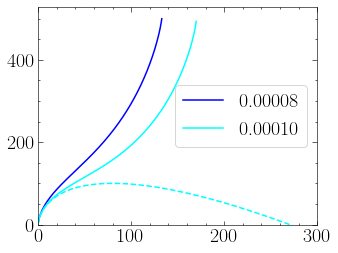

In [164]:
N_test_5=170
FUS_nk_5=np.linspace(0, N_test_5*2, num=10000)
V_test_5=120**3
FUS_p0_5=kT*N_test_5/V_test_5
FUS_r_test_5=np.power(3*FUS_nk_5*vlFUS/4/np.pi,1/3);
FUS_FES_test_5=FES_confined_test(FUS_nk_5,N_test_5,peq_FUS_estimate,sigma_FUS_estimate,FUS_p0_5,vlFUS,FUS_r_test_5,kT,V_test_5)
FUS_FESm_test_5=FES_macro_test(FUS_nk_5, peq_FUS_estimate, sigma_FUS_estimate, FUS_p0_5, FUS_r_test_5, kT)

plt.plot(FUS_nk_2,FUS_FES_test_2-FUS_FES_test_2[0],color="blue",ls="-",label="0.00008")
plt.plot(FUS_nk_5,FUS_FES_test_5-FUS_FES_test_5[0],color="cyan",ls="-",label="0.00010")
plt.plot(FUS_nk_5,FUS_FESm_test_5-FUS_FESm_test_5[0],color="cyan",ls="--")
plt.ylim(0,)
plt.xlim(0,300)
plt.legend()

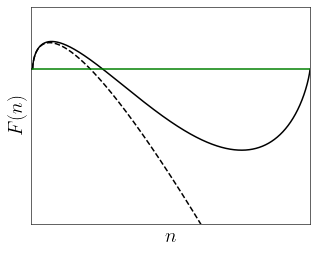

In [165]:
N_test_5=90
FUS_nk_5=np.linspace(0, N_test_5, num=10000)
V_test_5=60**3
FUS_p0_5=kT*N_test_5/V_test_5
FUS_r_test_5=np.power(3*FUS_nk_5*vlFUS/4/np.pi,1/3);
FUS_FES_test_5=FES_confined_test(FUS_nk_5,N_test_5,peq_FUS_estimate,sigma_FUS_estimate,FUS_p0_5,vlFUS,FUS_r_test_5,kT,V_test_5)
FUS_FESm_test_5=FES_macro_test(FUS_nk_5, peq_FUS_estimate, sigma_FUS_estimate, FUS_p0_5, FUS_r_test_5, kT)
plt.plot(FUS_nk_5,FUS_FES_test_5-FUS_FES_test_5[0],color="black",ls="-")
plt.plot(FUS_nk_5,FUS_FESm_test_5-FUS_FESm_test_5[0],color="black",ls="--")
plt.ylim(-100,40)
plt.xlim(-0.5,90)
plt.xticks([])
plt.yticks([])
plt.xlabel(r"$n$")
plt.ylabel(r"$F(n)$")
plt.axhline(y=0,ls="-",color="green",lw=1.5)
plt.savefig('poster', dpi=600, bbox_inches='tight');

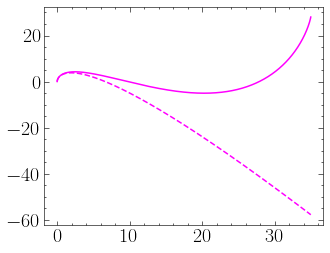

In [166]:
N_test_5=35
DDX_nk_5=np.linspace(0, N_test_5, num=10000)
V_test_5=40**3
DDX_p0_5=kT*N_test_5/V_test_5
DDX_r_test_5=np.power(3*DDX_nk_5*vlDDX/4/np.pi,1/3);
DDX_FES_test_5=FES_confined_test(DDX_nk_5,N_test_5,peq_DDX_estimate,sigma_DDX_estimate,DDX_p0_5,vlDDX,DDX_r_test_5,kT,V_test_5)
DDX_FESm_test_5=FES_macro_test(DDX_nk_5, peq_DDX_estimate, sigma_DDX_estimate, DDX_p0_5, DDX_r_test_5, kT)
plt.plot(DDX_nk_5,DDX_FES_test_5-DDX_FES_test_5[0],color="magenta",ls="-")
plt.plot(DDX_nk_5,DDX_FESm_test_5-DDX_FESm_test_5[0],color="magenta",ls="--")
#plt.ylim(-20,100)
#plt.xlim(0,400)

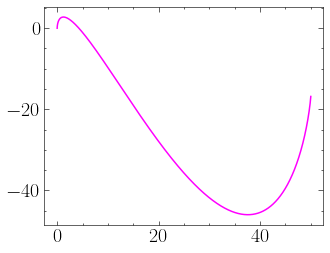

In [167]:
N_test_5=50
DDX_nk_5=np.linspace(0, N_test_5, num=10000)
V_test_5=40**3
DDX_p0_5=kT*N_test_5/V_test_5
DDX_r_test_5=np.power(3*DDX_nk_5*vlDDX/4/np.pi,1/3);
DDX_FES_test_5=FES_confined_test(DDX_nk_5,N_test_5,peq_DDX_estimate,sigma_DDX_estimate,DDX_p0_5,vlDDX,DDX_r_test_5,kT,V_test_5)
DDX_FESm_test_5=FES_macro_test(DDX_nk_5, peq_DDX_estimate, sigma_DDX_estimate, DDX_p0_5, DDX_r_test_5, kT)
plt.plot(DDX_nk_5,DDX_FES_test_5-DDX_FES_test_5[0],color="magenta",ls="-")
#plt.plot(DDX_nk_5,DDX_FESm_test_5-DDX_FESm_test_5[0],color="magenta",ls="--")
#plt.ylim(-20,100)
#plt.xlim(0,400)

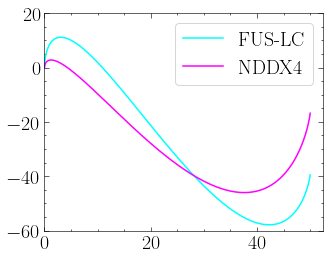

In [168]:
N_test_6=50
FUS_nk_6=np.linspace(0, N_test_6, num=10000)
V_test_6=40**3
FUS_p0_6=kT*N_test_6/V_test_6
FUS_r_test_6=np.power(3*FUS_nk_6*vlFUS/4/np.pi,1/3);
FUS_FES_test_6=FES_confined_test(FUS_nk_6,N_test_6,peq_FUS_estimate,sigma_FUS_estimate,FUS_p0_6,vlFUS,FUS_r_test_6,kT,V_test_6)
FUS_FESm_test_6=FES_macro_test(FUS_nk_6, peq_FUS_estimate, sigma_FUS_estimate, FUS_p0_6, FUS_r_test_6, kT)
plt.plot(FUS_nk_6,FUS_FES_test_6-FUS_FES_test_6[0],color="cyan",ls="-",label="FUS-LC")
plt.plot(DDX_nk_5,DDX_FES_test_5-DDX_FES_test_5[0],color="magenta",ls="-",label="NDDX4")
plt.ylim(-60,20)
plt.xlim(0,)
plt.legend()

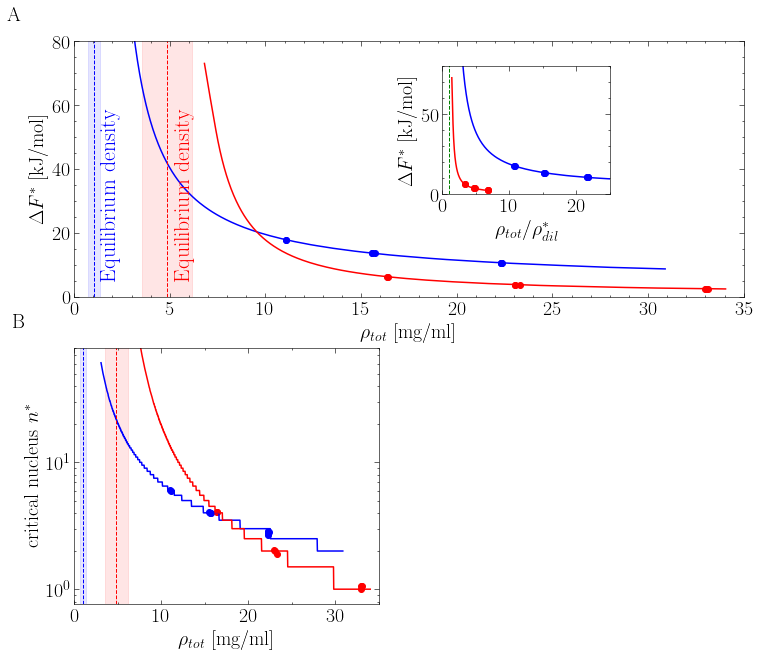

In [169]:
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator

## Define FES confined and macroscopic
FES_confined=lambda nn, N, peq, sigma, p0, p1, vl, r, kT, : -nn*kT*np.log(p1/peq)+sigma*4*np.pi*np.power(r,2)+nn*(kT-vl*peq)+N*kT*np.log(p1/p0);
FES_macro=lambda nn, peq, sigma, p0, r, kT, : -nn*kT*np.log(p0/peq)+sigma*4*np.pi*np.power(r,2);

## Plot sub-figures setup
fig = plt.figure(figsize=(12, 16))
sub1 = fig.add_subplot(3,2,3)
sub2 = fig.add_subplot(3,2,4)
sub3 = fig.add_subplot(3,2,(1,2))

## labels
sub1.set_xlabel('$\\rho_d^\circ$ [mg/ml]')
sub1.set_ylabel('critical nucleus $n^*$')
sub3.set_xlabel('$\\rho_d^\circ$ [mg/ml]')
sub3.set_ylabel('$\\Delta{F}^*$ [kJ/mol]')

## insets
ax3 = plt.axes([1,1,1,1])
ip2 = InsetPosition(sub3, [0.55,0.4,0.25,0.5])
ax3.set_axes_locator(ip2)
ax3.set_xlabel('$\\rho_d^\circ/\\rho^*_{dil}$')
ax3.set_ylabel('$\\Delta{F}^*$ [kJ/mol]')

## label## 
sub1.text(-0.2, 1.10, 'B', transform=sub1.transAxes,verticalalignment='center')
sub3.text(-0.1, 1.10, 'A', transform=sub3.transAxes,verticalalignment='center')

sub3.set_xlim([0,35])
sub1.set_xlim([0,35])
ax3.set_xlim([0,25])
#######################################################################
sub2.axis('off')
#######################################################################
#compute FUS Free Energies (and plot panel 1)
for SIM in np.arange(0,NsimulationsFUS):
    #Compute FES given the fitted parameters
    nn=np.linspace(0, dataFUS.Ntot[SIM]-1, num=1000)
    p0=p0FUS[SIM]
    p1=kT*(dataFUS.Ntot[SIM]-nn)/(VFUS[SIM]-nn*vlFUS)
    r=np.power(3*nn*vlFUS/4/np.pi,1/3);
    FES=FES_confined(nn,dataFUS.Ntot[SIM],peq_FUS_estimate,sigma_FUS_estimate,p0,p1,vlFUS,r,kT)   
    FESm=FES_macro(nn, peq_FUS_estimate, sigma_FUS_estimate, p0, r, kT)
    #compute steady state droplet size, critical nucleus size, and nucleation barrier
    argminF_FUS[SIM]=nn[FES==np.min(FES)]
    argmaxF_FUS[SIM]=nn[FESm==np.max(FESm)]
    DF_FUS[SIM]=np.max(FESm)
    #plot stuff in subpanels
    sub3.scatter(p0*ml_nm3*weightFUS/kT,DF_FUS[SIM],color='blue')
    sub1.scatter(p0*ml_nm3*weightFUS/kT,argmaxF_FUS[SIM],color='blue')
    ax3.scatter(p0*ml_nm3*weightFUS/kT/LD_FUS_estimate,DF_FUS[SIM],color='blue')

#NDDX4 Free Energies (and plot panel 1)    
for SIM in np.arange(0,NsimulationsDDX):
    #Compute FES given the fitted parameters
    nn=np.linspace(0, dataDDX.Ntot[SIM]-1, num=1000)
    p0=p0DDX[SIM]
    p1=kT*(dataDDX.Ntot[SIM]-nn)/(VDDX[SIM]-nn*vlDDX)
    r=np.power(3*nn*vlDDX/4/np.pi,1/3);
    FES=FES_confined(nn,dataDDX.Ntot[SIM],peq_DDX_estimate,sigma_DDX_estimate,p0,p1,vlDDX,r,kT)   
    FESm=FES_macro(nn, peq_DDX_estimate, sigma_DDX_estimate, p0, r, kT)
    #compute steady state droplet size, critical nucleus size, and nucleation barrier
    argminF_DDX[SIM]=nn[FES==np.min(FES)]
    argmaxF_DDX[SIM]=nn[FESm==np.max(FESm)]
    DF_DDX[SIM]=np.max(FESm)
    #plot stuff in subpanels
    sub3.scatter(p0*ml_nm3*weightDDX/kT,DF_DDX[SIM],color='red')
    sub1.scatter(p0*ml_nm3*weightDDX/kT,argmaxF_DDX[SIM],color='red') 
    ax3.scatter(p0*ml_nm3*weightDDX/kT/LD_DDX_estimate,DF_DDX[SIM],color='red')
   
        
####inset scale
ax3.set_ylim(0,80)
ax3.set_xticks([0, 10, 20])
ax3.xaxis.set_minor_locator(AutoMinorLocator(2))
ax3.plot([1,1],[0, 100],'--',color="green",Linewidth=1.0)

#Compute nucleation barrier and critical nucleus size as a function of system size from the model
#FUS
nn=np.linspace(0, 500, num=1000)
P0=np.linspace(peq_FUS_estimate*3,peq_FUS_estimate*30,1000)
DFFUS=np.zeros(np.shape(P0))
ncritFUS=np.zeros(np.shape(P0))
for i in np.arange(0,np.shape(P0)[0]):
    p0=P0[i]
    r=np.power(3*nn*vlFUS/4/np.pi,1/3);
    FESm=FES_macro(nn, peq_FUS_estimate, sigma_FUS_estimate, p0, r, kT)
    DFFUS[i]=np.max(FESm)
    ncritFUS[i]=nn[FESm==np.max(FESm)]
sub3.plot(P0*ml_nm3*weightFUS/kT,DFFUS,'b')
sub1.plot(P0*ml_nm3*weightFUS/kT,ncritFUS,'b')
ax3.plot(P0*ml_nm3*weightFUS/kT/LD_FUS_estimate,DFFUS,'b')

#DDX4 
P0=np.linspace(peq_DDX_estimate*1.4,peq_DDX_estimate*7,1000)
DFDDX=np.zeros(np.shape(P0))
ncritDDX=np.zeros(np.shape(P0))
for i in np.arange(0,np.shape(P0)[0]):
    p0=P0[i]
    r=np.power(3*nn*vlDDX/4/np.pi,1/3);
    FESm=FES_macro(nn, peq_DDX_estimate, sigma_DDX_estimate, p0, r, kT)
    DFDDX[i]=np.max(FESm[1:200])
    ncritDDX[i]=nn[FESm==np.max(FESm)]
sub3.plot(P0*ml_nm3*weightDDX/kT,DFDDX,'r')
sub1.plot(P0*ml_nm3*weightDDX/kT,ncritDDX,'r')
ax3.plot(P0*ml_nm3*weightDDX/kT/LD_DDX_estimate,DFDDX,'r')

#plot critical nucleus sizes in inset
sub1.plot([LD_FUS_estimate, LD_FUS_estimate],[0, 80],'--b',Linewidth=1.0)
sub1.plot([LD_DDX_estimate, LD_DDX_estimate],[0, 80],'--r',Linewidth=1.0)
sub1.add_patch(Rectangle((LD_DDX_estimate-LD_DDX_err, 0), 2*LD_DDX_err, 100,color='red',alpha=0.1))
sub1.add_patch(Rectangle((LD_FUS_estimate-LD_FUS_err, 0), 2*LD_FUS_err, 100,color='blue',alpha=0.1))
sub1.set_yscale("log")
sub1.set_ylim([0,80])
sub1.set_xticks([0, 10, 20, 30])
sub1.xaxis.set_minor_locator(AutoMinorLocator(2))

#plot equilibrium density estimate with confidence interval
sub3.plot([LD_FUS_estimate, LD_FUS_estimate],[0, 80],'--b',Linewidth=1.0)
sub3.plot([LD_DDX_estimate, LD_DDX_estimate],[0, 80],'--r',Linewidth=1.0)
sub3.add_patch(Rectangle((LD_DDX_estimate-LD_DDX_err, 0), 2*LD_DDX_err, 100,color='red',alpha=0.1))
sub3.add_patch(Rectangle((LD_FUS_estimate-LD_FUS_err, 0), 2*LD_FUS_err, 100,color='blue',alpha=0.1))
sub3.set_ylim([0,80])
#############################################
sub3.text(0.15, 0.4, "Equilibrium density", transform=sub3.transAxes, fontsize=22,verticalalignment='center', 
          bbox=None,rotation=90,color="red")
sub3.text(0.04, 0.4, "Equilibrium density", transform=sub3.transAxes, fontsize=22,verticalalignment='center', 
          bbox=None,rotation=90,color="blue")
#############################################
# Save it! 
plt.savefig('poster_3.png', dpi=600, bbox_inches='tight');